In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import fsolve

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


## DATA

In [4]:
title = "LQ down 1600 GeV"

In [5]:
##############
# input data #
##############

# b1,b2 -> (pT, eta, phi) from the leading and second b-tagged jets
# tau -> (pT, eta, phi) from the tau
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets, num_btag)  HT: sum PT of all the jets, number of jets (b-tag or not), number of b-tagged jets


################
# New Physics: #
################

datFolderNP = '../DATA/signal/dats-LQdown-1600GeV/'
k_LQdown = 1.8247261601649074
crossfidNP = 0.012251861577200002*k_LQdown

b1_NP = np.loadtxt(datFolderNP + 'b1.dat', delimiter=' ')
b2_NP = np.loadtxt(datFolderNP + 'b2.dat', delimiter=' ')
tau_NP = np.loadtxt(datFolderNP + 'tau.dat', delimiter=' ')
MET_NP = np.loadtxt(datFolderNP + 'MET.dat', delimiter=' ')
hadinfo_NP = np.loadtxt(datFolderNP + 'hadinfo.dat', delimiter=' ')

print('# eventos LQ: ', len(b1_NP))



###############
# Background: #
###############

# tt and fakett

datFolderSM_tt = '../DATA/background/dats-tt/'

k_fakett = 1.1053030485310749
crossfid_fakett = 0.244
k_tt = 1.2593273872014419
crossfid_tt = (7.74198*k_tt) + (crossfid_fakett * k_fakett)

b1_SM_tt = np.loadtxt(datFolderSM_tt + 'b1.dat', delimiter=' ')
b2_SM_tt = np.loadtxt(datFolderSM_tt + 'b2.dat', delimiter=' ')
tau_SM_tt = np.loadtxt(datFolderSM_tt + 'tau.dat', delimiter=' ')
MET_SM_tt = np.loadtxt(datFolderSM_tt + 'MET.dat', delimiter=' ')
hadinfo_SM_tt = np.loadtxt(datFolderSM_tt + 'hadinfo.dat', delimiter=' ')

print('# eventos tt: ', len(b1_SM_tt))


# singlet part 1

datFolderSM_singletP1 = '../DATA/background/dats-singletP1/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP1 = 0.632632*k_singletTOTAL

b1_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b1.dat', delimiter=' ')
b2_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b2.dat', delimiter=' ')
tau_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'tau.dat', delimiter=' ')
MET_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 1: ', len(b1_SM_singletP1))


# singlet part 2

datFolderSM_singletP2 = '../DATA/background/dats-singlet-comp/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP2 = 0.3182704*k_singletTOTAL

b1_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b1.dat', delimiter=' ')
b2_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b2.dat', delimiter=' ')
tau_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'tau.dat', delimiter=' ')
MET_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 2: ', len(b1_SM_singletP2))


# Wbbjets

datFolderSM_Wbbjets = '../DATA/background/dats-Wbbjets/'
k_wjets = 0.9781509289273502
crossfid_Wbbjets = 1.6542420183645095*k_wjets

b1_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b1.dat', delimiter=' ')
b2_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b2.dat', delimiter=' ')
tau_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'tau.dat', delimiter=' ')
MET_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'MET.dat', delimiter=' ')
hadinfo_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'hadinfo.dat', delimiter=' ')

print('# eventos Wbbjets: ', len(b1_SM_Wbbjets))


# ttW (part of ttV)

datFolderSM_ttW = '../DATA/background/dats-ttW/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttW = 0.03683196*k_ttV

b1_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b1.dat', delimiter=' ')
b2_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b2.dat', delimiter=' ')
tau_SM_ttW = np.loadtxt(datFolderSM_ttW + 'tau.dat', delimiter=' ')
MET_SM_ttW = np.loadtxt(datFolderSM_ttW + 'MET.dat', delimiter=' ')
hadinfo_SM_ttW = np.loadtxt(datFolderSM_ttW + 'hadinfo.dat', delimiter=' ')

print('# eventos ttW: ', len(b1_SM_ttW))


# ttZ

datFolderSM_ttZ = '../DATA/background/dats-ttZ/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttZ = 0.0715444*k_ttV

b1_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b1.dat', delimiter=' ')
b2_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b2.dat', delimiter=' ')
tau_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'tau.dat', delimiter=' ')
MET_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'MET.dat', delimiter=' ')
hadinfo_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'hadinfo.dat', delimiter=' ')

print('# eventos ttZ: ', len(b1_SM_ttZ))


# ttH

datFolderSM_ttH = '../DATA/background/dats-ttH/'
k_ttH = 2.2127445612386474
crossfid_ttH = 0.03630132*k_ttH

b1_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b1.dat', delimiter=' ')
b2_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b2.dat', delimiter=' ')
tau_SM_ttH = np.loadtxt(datFolderSM_ttH + 'tau.dat', delimiter=' ')
MET_SM_ttH = np.loadtxt(datFolderSM_ttH + 'MET.dat', delimiter=' ')
hadinfo_SM_ttH = np.loadtxt(datFolderSM_ttH + 'hadinfo.dat', delimiter=' ')

print('# eventos ttH: ', len(b1_SM_ttH))

# eventos LQ:  447538
# eventos tt:  826022
# eventos singlet part 1:  179677
# eventos singlet part 2:  94219
# eventos Wbbjets:  162448
# eventos ttW:  141919
# eventos ttZ:  16178
# eventos ttH:  12068


In [6]:
# Number of data points (per-class) for the ML classifier
num_data_NP = int(len(b1_NP)-1)
print(' SIGNAL ')
print('# S chosen: ', num_data_NP)



totalcrossSM = crossfid_tt + crossfid_singletP1+crossfid_singletP2 + crossfid_Wbbjets + crossfid_ttW+crossfid_ttZ + crossfid_ttH

num_data_SM_singletP1 = round( num_data_NP * (crossfid_singletP1/totalcrossSM) )
num_data_SM_singletP2 = round( num_data_NP * (crossfid_singletP2/totalcrossSM) )
num_data_SM_Wbbjets = round( num_data_NP * (crossfid_Wbbjets/totalcrossSM) )
num_data_SM_ttW = round( num_data_NP * (crossfid_ttW/totalcrossSM) )
num_data_SM_ttZ = round( num_data_NP * (crossfid_ttZ/totalcrossSM) )
num_data_SM_ttH = round( num_data_NP * (crossfid_ttH/totalcrossSM) )

num_data_SM_tt = num_data_NP - (num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ + num_data_SM_ttH)

num_data_SM = num_data_SM_tt + num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ +  num_data_SM_ttH


print('\n BACKGROUND ')
print('# tt chosen: ', num_data_SM_tt)
print('# singletP1 chosen: ', num_data_SM_singletP1)
print('# singletP2 chosen: ', num_data_SM_singletP2)
print('# Wbbjets chosen: ', num_data_SM_Wbbjets)
print('# ttW chosen: ', num_data_SM_ttW)
print('# ttZ chosen: ', num_data_SM_ttZ)
print('# ttH chosen: ', num_data_SM_ttH)

print('\n# total B eventos chosen: ', num_data_SM)



# CHECK IF THE NUMBER OF EVENTS ARE CORRECT
if num_data_SM == num_data_NP and num_data_NP < len(b1_NP) and num_data_SM_tt < len(b1_SM_tt) and num_data_SM_singletP1 < len(b1_SM_singletP1) and num_data_SM_singletP2 < len(b1_SM_singletP2) and num_data_SM_Wbbjets < len(b1_SM_Wbbjets) and num_data_SM_ttW < len(b1_SM_ttW) and num_data_SM_ttZ < len(b1_SM_ttZ) and num_data_SM_ttH < len(b1_SM_ttH):
    print( '\nEverything OK, continue')
else:
    print( '\nThe number of events of each channel not enought, check if you need to generate more')

 SIGNAL 
# S chosen:  447537

 BACKGROUND 
# tt chosen:  292678
# singletP1 chosen:  63583
# singletP2 chosen:  31988
# Wbbjets chosen:  47266
# ttW chosen:  3288
# ttZ chosen:  6388
# ttH chosen:  2346

# total B eventos chosen:  447537

Everything OK, continue


In [7]:
# KEEP ONLY THE NUMBER OF SIGNAL EVENTS THAT WE WILL USE
b1_NP = b1_NP[:num_data_NP]
b2_NP = b2_NP[:num_data_NP]
tau_NP = tau_NP[:num_data_NP]
MET_NP = MET_NP[:num_data_NP]
hadinfo_NP = hadinfo_NP[:num_data_NP]


# CONCATENATE YOUR SELECTED BACKGROUNDS (as many as you want, with the correct proportion)

b1_SM = np.concatenate((b1_SM_tt[:num_data_SM_tt],b1_SM_singletP1[:num_data_SM_singletP1],b1_SM_singletP2[:num_data_SM_singletP2],b1_SM_Wbbjets[:num_data_SM_Wbbjets],b1_SM_ttW[:num_data_SM_ttW],b1_SM_ttZ[:num_data_SM_ttZ],b1_SM_ttH[:num_data_SM_ttH]))
b2_SM = np.concatenate((b2_SM_tt[:num_data_SM_tt],b2_SM_singletP1[:num_data_SM_singletP1],b2_SM_singletP2[:num_data_SM_singletP2],b2_SM_Wbbjets[:num_data_SM_Wbbjets],b2_SM_ttW[:num_data_SM_ttW],b2_SM_ttZ[:num_data_SM_ttZ],b2_SM_ttH[:num_data_SM_ttH]))
tau_SM = np.concatenate((tau_SM_tt[:num_data_SM_tt],tau_SM_singletP1[:num_data_SM_singletP1],tau_SM_singletP2[:num_data_SM_singletP2],tau_SM_Wbbjets[:num_data_SM_Wbbjets],tau_SM_ttW[:num_data_SM_ttW],tau_SM_ttZ[:num_data_SM_ttZ],tau_SM_ttH[:num_data_SM_ttH]))
MET_SM = np.concatenate((MET_SM_tt[:num_data_SM_tt],MET_SM_singletP1[:num_data_SM_singletP1],MET_SM_singletP2[:num_data_SM_singletP2],MET_SM_Wbbjets[:num_data_SM_Wbbjets],MET_SM_ttW[:num_data_SM_ttW],MET_SM_ttZ[:num_data_SM_ttZ],MET_SM_ttH[:num_data_SM_ttH]))
hadinfo_SM = np.concatenate((hadinfo_SM_tt[:num_data_SM_tt],hadinfo_SM_singletP1[:num_data_SM_singletP1],hadinfo_SM_singletP2[:num_data_SM_singletP2],hadinfo_SM_Wbbjets[:num_data_SM_Wbbjets],hadinfo_SM_ttW[:num_data_SM_ttW],hadinfo_SM_ttZ[:num_data_SM_ttZ],hadinfo_SM_ttH[:num_data_SM_ttH]))

del b1_SM_tt
del b2_SM_tt
del tau_SM_tt
del MET_SM_tt
del hadinfo_SM_tt

del b1_SM_singletP1
del b2_SM_singletP1
del tau_SM_singletP1
del MET_SM_singletP1
del hadinfo_SM_singletP1

del b1_SM_singletP2
del b2_SM_singletP2
del tau_SM_singletP2
del MET_SM_singletP2
del hadinfo_SM_singletP2

del b1_SM_Wbbjets
del b2_SM_Wbbjets
del tau_SM_Wbbjets
del MET_SM_Wbbjets
del hadinfo_SM_Wbbjets

del b1_SM_ttW
del b2_SM_ttW
del tau_SM_ttW
del MET_SM_ttW
del hadinfo_SM_ttW

del b1_SM_ttZ
del b2_SM_ttZ
del tau_SM_ttZ
del MET_SM_ttZ
del hadinfo_SM_ttZ

del b1_SM_ttH
del b2_SM_ttH
del tau_SM_ttH
del MET_SM_ttH
del hadinfo_SM_ttH

In [8]:
print('# Background events: ', len(b1_SM))
print('# Signal events: ', len(b1_NP))

# Background events:  447537
# Signal events:  447537


### pdfs

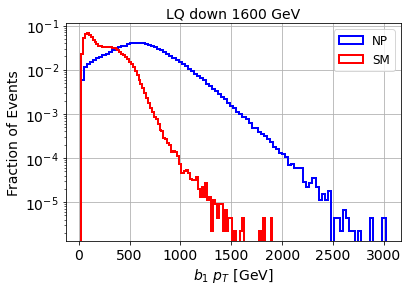

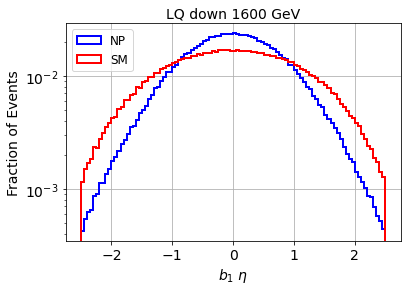

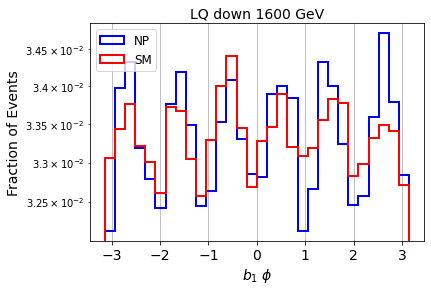

In [9]:
weights = np.ones_like(b1_NP[:,0])/float(len(b1_NP[:,0]))
plt.hist(b1_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,0])/float(len(b1_SM[:,0]))
plt.hist(b1_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,1])/float(len(b1_NP[:,1]))
plt.hist(b1_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,1])/float(len(b1_SM[:,1]))
plt.hist(b1_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,2])/float(len(b1_NP[:,2]))
plt.hist(b1_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,2])/float(len(b1_SM[:,2]))
plt.hist(b1_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

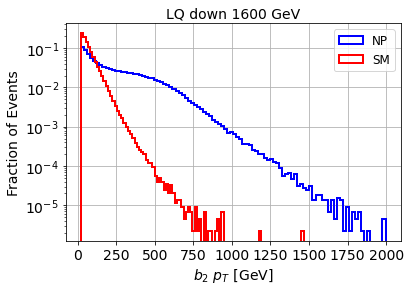

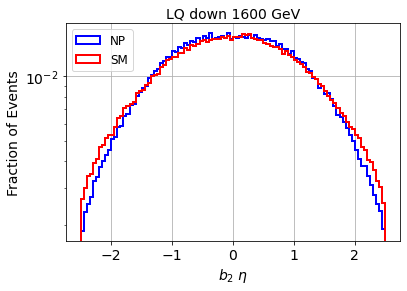

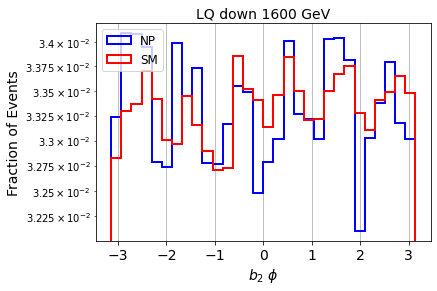

In [10]:
weights = np.ones_like(b2_NP[:,0])/float(len(b2_NP[:,0]))
plt.hist(b2_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,0])/float(len(b2_SM[:,0]))
plt.hist(b2_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,1])/float(len(b2_NP[:,1]))
plt.hist(b2_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,1])/float(len(b2_SM[:,1]))
plt.hist(b2_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,2])/float(len(b2_NP[:,2]))
plt.hist(b2_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,2])/float(len(b2_SM[:,2]))
plt.hist(b2_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

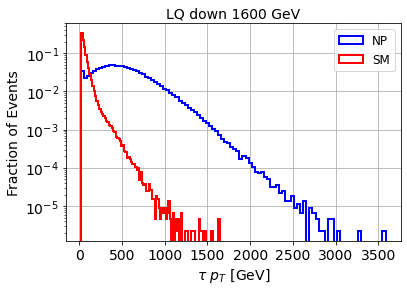

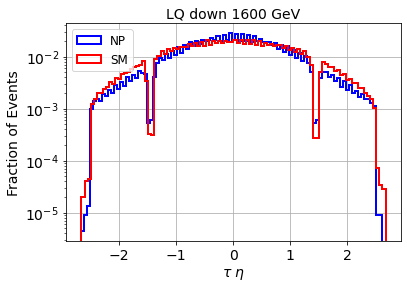

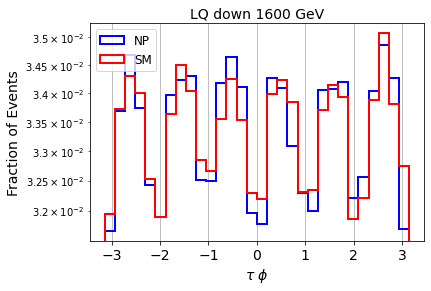

In [11]:
weights = np.ones_like(tau_NP[:,0])/float(len(tau_NP[:,0]))
plt.hist(tau_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,0])/float(len(tau_SM[:,0]))
plt.hist(tau_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,1])/float(len(tau_NP[:,1]))
plt.hist(tau_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,1])/float(len(tau_SM[:,1]))
plt.hist(tau_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,2])/float(len(tau_NP[:,2]))
plt.hist(tau_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,2])/float(len(tau_SM[:,2]))
plt.hist(tau_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

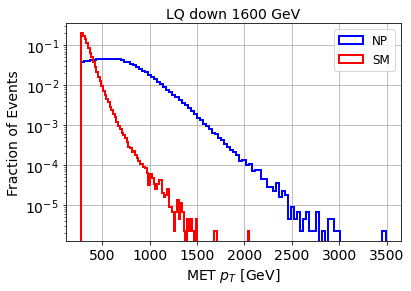

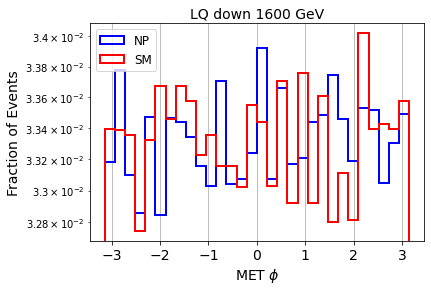

In [12]:
weights = np.ones_like(MET_NP[:,0])/float(len(MET_NP[:,0]))
plt.hist(MET_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,0])/float(len(MET_SM[:,0]))
plt.hist(MET_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()


weights = np.ones_like(MET_NP[:,2])/float(len(MET_NP[:,2]))
plt.hist(MET_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,2])/float(len(MET_SM[:,2]))
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

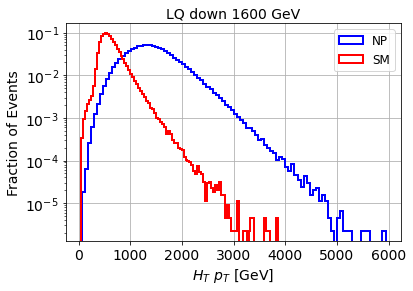

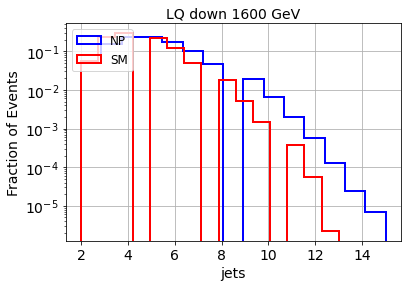

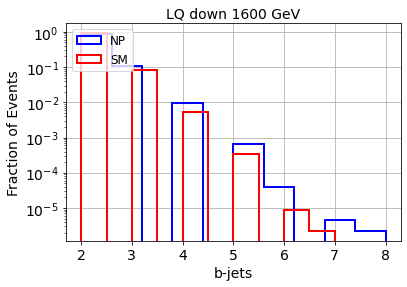

In [13]:
weights = np.ones_like(hadinfo_NP[:,0])/float(len(hadinfo_NP[:,0]))
plt.hist(hadinfo_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,0])/float(len(hadinfo_SM[:,0]))
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$H_T$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,1])/float(len(hadinfo_NP[:,1]))
plt.hist(hadinfo_NP[:,1], weights=weights, bins=15, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,1])/float(len(hadinfo_SM[:,1]))
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,2])/float(len(hadinfo_NP[:,2]))
plt.hist(hadinfo_NP[:,2], weights=weights, bins=10, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,2])/float(len(hadinfo_SM[:,2]))
plt.hist(hadinfo_SM[:,2], weights=weights, bins=10, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("b-jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

### Train-test-val Dataset

In [14]:
# to normalize
scaler = preprocessing.MinMaxScaler()

# DATA WITH UNCERTAINTIES
err_pt_tau_SM = 0.1
err_pt_tau_NP = 0.

tau_SM_pt_upB = [i*(1. + err_pt_tau_SM) for i in tau_SM[:,0]]
tau_NP_pt_upB = [i*(1. + err_pt_tau_NP) for i in tau_NP[:,0]]

tau_SM_pt_downB = [i*(1. - err_pt_tau_SM) for i in tau_SM[:,0]]
tau_NP_pt_downB = [i*(1. - err_pt_tau_NP) for i in tau_NP[:,0]]



df = pd.DataFrame()

df['b1-pt']= np.concatenate([b1_SM[:,0],b1_NP[:,0]])
df['b1-eta']= np.concatenate([b1_SM[:,1],b1_NP[:,1]])
df['b1-phi']= np.concatenate([b1_SM[:,2],b1_NP[:,2]])
# remove the used data
del b1_SM
del b1_NP

df['b2-pt']= np.concatenate([b2_SM[:,0],b2_NP[:,0]])
df['b2-eta']= np.concatenate([b2_SM[:,1],b2_NP[:,1]])
df['b2-phi']= np.concatenate([b2_SM[:,2],b2_NP[:,2]])
# remove the used dat
del b2_SM
del b2_NP

df['tau-pt']= np.concatenate([tau_SM[:,0],tau_NP[:,0]])
df['tau-eta']= np.concatenate([tau_SM[:,1],tau_NP[:,1]])
df['tau-phi']= np.concatenate([tau_SM[:,2],tau_NP[:,2]])
# remove the used data
del tau_SM
del tau_NP

df['MET-pt']= np.concatenate([MET_SM[:,0],MET_NP[:,0]])
df['MET-phi']= np.concatenate([MET_SM[:,2],MET_NP[:,2]])
# remove the used data
del MET_SM
del MET_NP

df['HT-pt']= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[:,0]])
df['num-jets']= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[:,1]])
df['num-bjets']= np.concatenate([hadinfo_SM[:,2],hadinfo_NP[:,2]])
# remove the used data
del hadinfo_SM
del hadinfo_NP

df['Y'] = np.concatenate([np.zeros(num_data_SM),np.ones(num_data_NP)])



#df_upB = pd.DataFrame()
df_upB = df.copy()
df_upB['tau-pt'] = np.concatenate([tau_SM_pt_upB,tau_NP_pt_upB])
del tau_SM_pt_upB
del tau_NP_pt_upB

df_downB = df.copy()
df_downB['tau-pt'] = np.concatenate([tau_SM_pt_downB,tau_NP_pt_downB])
del tau_SM_pt_downB
del tau_NP_pt_downB


# NORMALIZE
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# print df to see the data
print(df)


# X and Y for the classifier
X_mon = df[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_mon = df[['Y']].values


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)


X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)


print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

           b1-pt    b1-eta    b1-phi     b2-pt    b2-eta    b2-phi    tau-pt  \
0       0.008146  0.639656  0.978199  0.002737  0.475990  0.432368  0.004419   
1       0.018271  0.184874  0.496181  0.022634  0.532013  0.058243  0.001478   
2       0.032965  0.628651  0.564290  0.010709  0.573629  0.929822  0.008169   
3       0.078347  0.276110  0.337842  0.064885  0.332533  0.454806  0.019222   
4       0.038580  0.747299  0.141948  0.011003  0.855342  0.447804  0.004584   
...          ...       ...       ...       ...       ...       ...       ...   
895069  0.323836  0.382953  0.162794  0.181150  0.292517  0.041057  0.206647   
895070  0.196891  0.577231  0.491088  0.055246  0.083233  0.276575  0.259507   
895071  0.040495  0.536214  0.826544  0.059858  0.341737  0.802037  0.257889   
895072  0.064254  0.350540  0.594048  0.071443  0.630052  0.269414  0.194186   
895073  0.135074  0.485194  0.261776  0.001688  0.479792  0.405952  0.146685   

         tau-eta   tau-phi    MET-pt   

In [15]:
# DATA WITH UNCERTAINTIES +1sigma

# NORMALIZE
df_upB = scaler.fit_transform(df_upB)
df_upB = pd.DataFrame(df_upB,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# X and Y for the classifier
X_monupB = df_upB[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_monupB = df_upB[['Y']].values

del df_upB

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_monupB_aux, X_monupB_test, y_monupB_aux, y_monupB_test = train_test_split(X_monupB,
                                                                y_monupB,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_monupB,
                                                                shuffle=True)


X_monupB_train, X_monupB_val, y_monupB_train, y_monupB_val = train_test_split(X_monupB_aux,
                                                                  y_monupB_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_monupB_aux,
                                                                  shuffle=True)


print('')
print('X_monupB_train : ', X_monupB_train.shape)
print('y_monupB_train : ', y_monupB_train.shape)
print('X_monupB_val : ', X_monupB_val.shape)
print('y_monupB_val : ', y_monupB_val.shape)
print('X_monupB_test : ', X_monupB_test.shape)
print('y_monupB_test : ', y_monupB_test.shape)
print('')


X_monupB_train :  (447537, 14)
y_monupB_train :  (447537, 1)
X_monupB_val :  (149179, 14)
y_monupB_val :  (149179, 1)
X_monupB_test :  (298358, 14)
y_monupB_test :  (298358, 1)



In [16]:
# DATA WITH UNCERTAINTIES -1sigma

# NORMALIZE
df_downB = scaler.fit_transform(df_downB)
df_downB = pd.DataFrame(df_downB,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# X and Y for the classifier
X_mondownB = df_downB[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_mondownB = df_downB[['Y']].values

del df_downB

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mondownB_aux, X_mondownB_test, y_mondownB_aux, y_mondownB_test = train_test_split(X_mondownB,
                                                                y_mondownB,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mondownB,
                                                                shuffle=True)


X_mondownB_train, X_mondownB_val, y_mondownB_train, y_mondownB_val = train_test_split(X_mondownB_aux,
                                                                  y_mondownB_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mondownB_aux,
                                                                  shuffle=True)


print('')
print('X_mondownB_train : ', X_mondownB_train.shape)
print('y_mondownB_train : ', y_mondownB_train.shape)
print('X_mondownB_val : ', X_mondownB_val.shape)
print('y_mondownB_val : ', y_mondownB_val.shape)
print('X_mondownB_test : ', X_mondownB_test.shape)
print('y_mondownB_test : ', y_mondownB_test.shape)
print('')


X_mondownB_train :  (447537, 14)
y_mondownB_train :  (447537, 1)
X_mondownB_val :  (149179, 14)
y_mondownB_val :  (149179, 1)
X_mondownB_test :  (298358, 14)
y_mondownB_test :  (298358, 1)



### XGBoost (per-event)

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.60751	validation_1-logloss:0.60761
[1]	validation_0-logloss:0.53738	validation_1-logloss:0.53753
[2]	validation_0-logloss:0.47882	validation_1-logloss:0.47909
[3]	validation_0-logloss:0.42938	validation_1-logloss:0.42966
[4]	validation_0-logloss:0.38706	validation_1-logloss:0.38745
[5]	validation_0-logloss:0.35056	validation_1-logloss:0.35102
[6]	validation_0-logloss:0.31889	validation_1-logloss:0.31945
[7]	validation_0-logloss:0.29136	validation_1-logloss:0.29201
[8]	validation_0-logloss:0.26735	validation_1-logloss:0.26800
[9]	validation_0-logloss:0.24605	validation_1-logloss:0.24677
[10]	validation_0-logloss:0.22737	validation_1-logloss:0.22815
[11]	validation_0-logloss:0.21090	validation_1-logloss:0.21171
[12]	validation_0-logloss:0.19622	validation_1-logloss:0.19710
[13]	validation_0-logloss:0.18324	validation_1-logloss:0.18411
[14]	validation_0-logloss:0.17157	validation_1-logloss:0.17249
[15]	validation_0-logloss:0.16122	validation_1-logloss:0.16219
[1

[130]	validation_0-logloss:0.05518	validation_1-logloss:0.06128
[131]	validation_0-logloss:0.05511	validation_1-logloss:0.06125
[132]	validation_0-logloss:0.05509	validation_1-logloss:0.06125
[133]	validation_0-logloss:0.05505	validation_1-logloss:0.06123
[134]	validation_0-logloss:0.05503	validation_1-logloss:0.06122
[135]	validation_0-logloss:0.05499	validation_1-logloss:0.06121
[136]	validation_0-logloss:0.05493	validation_1-logloss:0.06117
[137]	validation_0-logloss:0.05489	validation_1-logloss:0.06116
[138]	validation_0-logloss:0.05486	validation_1-logloss:0.06115
[139]	validation_0-logloss:0.05460	validation_1-logloss:0.06089
[140]	validation_0-logloss:0.05457	validation_1-logloss:0.06088
[141]	validation_0-logloss:0.05452	validation_1-logloss:0.06085
[142]	validation_0-logloss:0.05448	validation_1-logloss:0.06085
[143]	validation_0-logloss:0.05442	validation_1-logloss:0.06086
[144]	validation_0-logloss:0.05439	validation_1-logloss:0.06084
[145]	validation_0-logloss:0.05437	valid

[259]	validation_0-logloss:0.04664	validation_1-logloss:0.05570
[260]	validation_0-logloss:0.04662	validation_1-logloss:0.05571
[261]	validation_0-logloss:0.04661	validation_1-logloss:0.05571
[262]	validation_0-logloss:0.04660	validation_1-logloss:0.05571
[263]	validation_0-logloss:0.04658	validation_1-logloss:0.05570
[264]	validation_0-logloss:0.04657	validation_1-logloss:0.05569
[265]	validation_0-logloss:0.04655	validation_1-logloss:0.05568
[266]	validation_0-logloss:0.04652	validation_1-logloss:0.05569
[267]	validation_0-logloss:0.04651	validation_1-logloss:0.05569
[268]	validation_0-logloss:0.04634	validation_1-logloss:0.05556
[269]	validation_0-logloss:0.04631	validation_1-logloss:0.05556
[270]	validation_0-logloss:0.04629	validation_1-logloss:0.05556
[271]	validation_0-logloss:0.04625	validation_1-logloss:0.05555
[272]	validation_0-logloss:0.04622	validation_1-logloss:0.05554
[273]	validation_0-logloss:0.04610	validation_1-logloss:0.05545
[274]	validation_0-logloss:0.04607	valid

[388]	validation_0-logloss:0.04095	validation_1-logloss:0.05266
[389]	validation_0-logloss:0.04093	validation_1-logloss:0.05265
[390]	validation_0-logloss:0.04091	validation_1-logloss:0.05266
[391]	validation_0-logloss:0.04090	validation_1-logloss:0.05266
[392]	validation_0-logloss:0.04089	validation_1-logloss:0.05266
[393]	validation_0-logloss:0.04085	validation_1-logloss:0.05265
[394]	validation_0-logloss:0.04078	validation_1-logloss:0.05263
[395]	validation_0-logloss:0.04075	validation_1-logloss:0.05263
[396]	validation_0-logloss:0.04073	validation_1-logloss:0.05263
[397]	validation_0-logloss:0.04069	validation_1-logloss:0.05263
[398]	validation_0-logloss:0.04053	validation_1-logloss:0.05247
[399]	validation_0-logloss:0.04050	validation_1-logloss:0.05247
[400]	validation_0-logloss:0.04042	validation_1-logloss:0.05241
[401]	validation_0-logloss:0.04034	validation_1-logloss:0.05235
[402]	validation_0-logloss:0.04028	validation_1-logloss:0.05232
[403]	validation_0-logloss:0.04026	valid

[517]	validation_0-logloss:0.03718	validation_1-logloss:0.05136
[518]	validation_0-logloss:0.03716	validation_1-logloss:0.05137
[519]	validation_0-logloss:0.03715	validation_1-logloss:0.05138
[520]	validation_0-logloss:0.03712	validation_1-logloss:0.05138
[521]	validation_0-logloss:0.03710	validation_1-logloss:0.05138
[522]	validation_0-logloss:0.03707	validation_1-logloss:0.05139
[523]	validation_0-logloss:0.03706	validation_1-logloss:0.05139
[524]	validation_0-logloss:0.03702	validation_1-logloss:0.05138
[525]	validation_0-logloss:0.03700	validation_1-logloss:0.05138
[526]	validation_0-logloss:0.03699	validation_1-logloss:0.05139
[527]	validation_0-logloss:0.03698	validation_1-logloss:0.05139
[528]	validation_0-logloss:0.03695	validation_1-logloss:0.05138
[529]	validation_0-logloss:0.03693	validation_1-logloss:0.05138
[530]	validation_0-logloss:0.03693	validation_1-logloss:0.05138
[531]	validation_0-logloss:0.03691	validation_1-logloss:0.05139
[532]	validation_0-logloss:0.03690	valid

[646]	validation_0-logloss:0.03431	validation_1-logloss:0.05077
[647]	validation_0-logloss:0.03428	validation_1-logloss:0.05077
[648]	validation_0-logloss:0.03428	validation_1-logloss:0.05078
[649]	validation_0-logloss:0.03427	validation_1-logloss:0.05077
[650]	validation_0-logloss:0.03426	validation_1-logloss:0.05078
[651]	validation_0-logloss:0.03425	validation_1-logloss:0.05079
[652]	validation_0-logloss:0.03423	validation_1-logloss:0.05080
[653]	validation_0-logloss:0.03422	validation_1-logloss:0.05080
[654]	validation_0-logloss:0.03421	validation_1-logloss:0.05081
[655]	validation_0-logloss:0.03419	validation_1-logloss:0.05081
[656]	validation_0-logloss:0.03416	validation_1-logloss:0.05081
[657]	validation_0-logloss:0.03415	validation_1-logloss:0.05081
[658]	validation_0-logloss:0.03413	validation_1-logloss:0.05081
[659]	validation_0-logloss:0.03412	validation_1-logloss:0.05080
[660]	validation_0-logloss:0.03411	validation_1-logloss:0.05081
[661]	validation_0-logloss:0.03411	valid

[775]	validation_0-logloss:0.03183	validation_1-logloss:0.05037
[776]	validation_0-logloss:0.03182	validation_1-logloss:0.05037
[777]	validation_0-logloss:0.03180	validation_1-logloss:0.05037
[778]	validation_0-logloss:0.03177	validation_1-logloss:0.05035
[779]	validation_0-logloss:0.03175	validation_1-logloss:0.05035
[780]	validation_0-logloss:0.03173	validation_1-logloss:0.05035
[781]	validation_0-logloss:0.03172	validation_1-logloss:0.05035
[782]	validation_0-logloss:0.03171	validation_1-logloss:0.05035
[783]	validation_0-logloss:0.03170	validation_1-logloss:0.05035
[784]	validation_0-logloss:0.03169	validation_1-logloss:0.05036
[785]	validation_0-logloss:0.03169	validation_1-logloss:0.05035
[786]	validation_0-logloss:0.03167	validation_1-logloss:0.05035
[787]	validation_0-logloss:0.03166	validation_1-logloss:0.05035
[788]	validation_0-logloss:0.03165	validation_1-logloss:0.05035
[789]	validation_0-logloss:0.03163	validation_1-logloss:0.05035
[790]	validation_0-logloss:0.03162	valid

[904]	validation_0-logloss:0.02958	validation_1-logloss:0.05001
[905]	validation_0-logloss:0.02956	validation_1-logloss:0.05001
[906]	validation_0-logloss:0.02954	validation_1-logloss:0.05000
[907]	validation_0-logloss:0.02952	validation_1-logloss:0.04999
[908]	validation_0-logloss:0.02950	validation_1-logloss:0.05000
[909]	validation_0-logloss:0.02948	validation_1-logloss:0.05000
[910]	validation_0-logloss:0.02948	validation_1-logloss:0.05000
[911]	validation_0-logloss:0.02947	validation_1-logloss:0.05001
[912]	validation_0-logloss:0.02946	validation_1-logloss:0.05001
[913]	validation_0-logloss:0.02944	validation_1-logloss:0.05001
[914]	validation_0-logloss:0.02943	validation_1-logloss:0.05002
[915]	validation_0-logloss:0.02942	validation_1-logloss:0.05001
[916]	validation_0-logloss:0.02940	validation_1-logloss:0.05002
[917]	validation_0-logloss:0.02938	validation_1-logloss:0.05002
[918]	validation_0-logloss:0.02936	validation_1-logloss:0.05003
[919]	validation_0-logloss:0.02935	valid

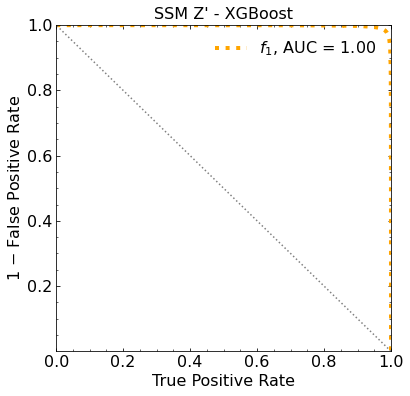

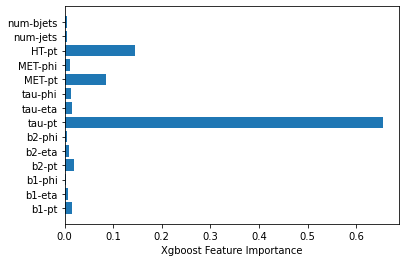

In [17]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"SSM Z' - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




# THIS IS THE DEFAULT FEATURE IMPORTANCE: gain
feature_names = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])
plt.barh(feature_names, classifier.feature_importances_)
plt.xlabel("Xgboost Feature Importance")
plt.show()

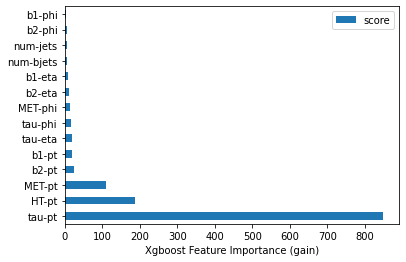

In [18]:
keys = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh') ## plot top 20 features
plt.xlabel("Xgboost Feature Importance (gain)")
plt.show()

Classification score:


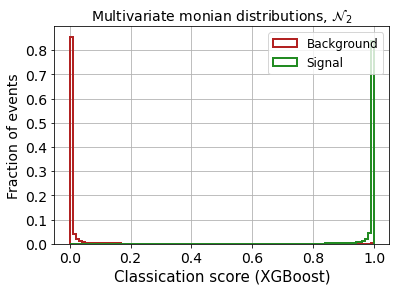

ROC AUC:        0.998292949875482
ROC AUC upB:    0.998095901755121
ROC AUC downB:  0.9984872864835898


In [19]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate monian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()




# DATA WITH UNCERTAINTIES +1sigma

# PREDICTIONS
y_pred_xgupB = classifier.predict_proba(X_monupB_test).T[1]


# ROC
fpr_mon_xgupB, tpr_mon_xgupB, _ = roc_curve(y_monupB_test, y_pred_xgupB)
roc_auc_xgupB = auc(fpr_mon_xgupB, tpr_mon_xgupB)

# Outputs for validation data set

pred_XG_SMupB = []
pred_XG_NPupB = []

for i in range(len(y_monupB_test)):
    if y_monupB_test[i] == 0:
        pred_XG_SMupB.append(y_pred_xgupB[i])
    else:
        pred_XG_NPupB.append(y_pred_xgupB[i])




# DATA WITH UNCERTAINTIES -1sigma

# PREDICTIONS
y_pred_xgdownB = classifier.predict_proba(X_mondownB_test).T[1]

# ROC
fpr_mon_xgdownB, tpr_mon_xgdownB, _ = roc_curve(y_mondownB_test, y_pred_xgdownB)
roc_auc_xgdownB = auc(fpr_mon_xgdownB, tpr_mon_xgdownB)

# Outputs for validation data set

pred_XG_SMdownB = []
pred_XG_NPdownB = []

for i in range(len(y_mondownB_test)):
    if y_mondownB_test[i] == 0:
        pred_XG_SMdownB.append(y_pred_xgdownB[i])
    else:
        pred_XG_NPdownB.append(y_pred_xgdownB[i])
        
        
        
print('ROC AUC:       ',roc_auc_xg)
print('ROC AUC upB:   ',roc_auc_xgupB)
print('ROC AUC downB: ',roc_auc_xgdownB)

In [20]:
# we choose the worst one to be conservative

## METHODS

### 0. Ensembles characteristics

In [21]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = round(300 * totalcrossSM)    # luminosity * cross * aceptance
print('B_expected: ', B_expected)

print('S_expected: ', round(300 * crossfidNP))    # luminosity * cross * aceptance
S_expected = [1,2,3,4,5,6,7,8,10]




# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = [ S_expected[iii]/(1.*B_expected) for iii in range(len(S_expected)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(S_expected)) ]

B_expected:  4596
S_expected:  7


In [22]:
300 * crossfidNP

6.706887699190838

### 1. BIN LOG LIKELIHOOD

In [23]:
MIN_EVS = 5

# Les't find the number of possible ensembles
N_ensembles_back = int(len(pred_XG_SM) / B_expected)
N_events_back = N_ensembles_back * B_expected


for bin_it in range(10,100):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(bin_it), range = [[0,1]])

    if min(hist_back) < MIN_EVS * N_ensembles_back:
        print('At least ' + str(MIN_EVS) + ' B events per bin, range = [[0,1]]:')
        print('# bins: ',bin_it,'NO ok')
        print(min(hist_back/N_ensembles_back))
        break
        
print('')

for bin_it in range(10,100):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(bin_it), range = [[min(pred_XG_SM[:N_events_back]),max(pred_XG_SM[:N_events_back])]])

    if min(hist_back) < MIN_EVS * N_ensembles_back:
        print('At least ' + str(MIN_EVS) + ' B events per bin, range = [[min(B),max(B)]]:')
        print('# bins: ',bin_it,'NO ok')
        print(min(hist_back/N_ensembles_back))
        break

At least 5 B events per bin, range = [[0,1]]:
# bins:  25 NO ok
4.8125

At least 5 B events per bin, range = [[min(B),max(B)]]:
# bins:  25 NO ok
4.8125


B_expected:  4596
S_expected:  1
S/$\sqrt{B}$:  0.014750610319128192

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



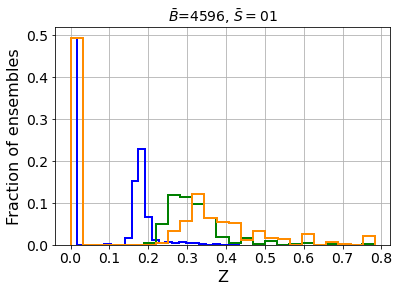

Z_bins_16bins:  0.15352471969283446
Z_bins_16bins_std:  0.09609887323686536
Z_bins_50bins:  0.22206979064183224
Z_bins_50bins_std:  0.16803833797463016
Z_bins_100bins:  0.2613006467800254
Z_bins_100bins_std:  0.21866995820218307

 -------------------------------- 

B_expected:  4596
S_expected:  2
S/$\sqrt{B}$:  0.029501220638256383

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



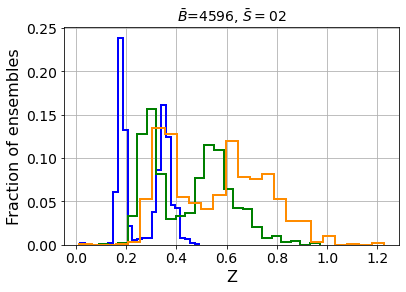

Z_bins_16bins:  0.31179238702983436
Z_bins_16bins_std:  0.09051330340176694
Z_bins_50bins:  0.46842217534975594
Z_bins_50bins_std:  0.15602170015630026
Z_bins_100bins:  0.5719070269289
Z_bins_100bins_std:  0.1919689506499189

 -------------------------------- 

B_expected:  4596
S_expected:  3
S/$\sqrt{B}$:  0.04425183095738457

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



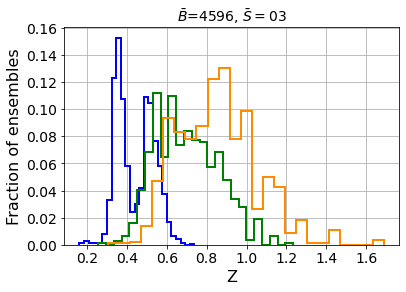

Z_bins_16bins:  0.42385805944799465
Z_bins_16bins_std:  0.09230142824383611
Z_bins_50bins:  0.691982906061105
Z_bins_50bins_std:  0.15721308435244719
Z_bins_100bins:  0.8376335649697051
Z_bins_100bins_std:  0.20160726085188777

 -------------------------------- 

B_expected:  4596
S_expected:  4
S/$\sqrt{B}$:  0.05900244127651277

 If  920  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



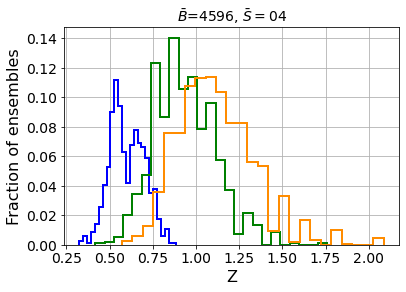

Z_bins_16bins:  0.591219268143734
Z_bins_16bins_std:  0.09841034009482212
Z_bins_50bins:  0.9365345489293795
Z_bins_50bins_std:  0.1782899403065825
Z_bins_100bins:  1.083004088109154
Z_bins_100bins_std:  0.2227574289295603

 -------------------------------- 

B_expected:  4596
S_expected:  5
S/$\sqrt{B}$:  0.07375305159564095

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



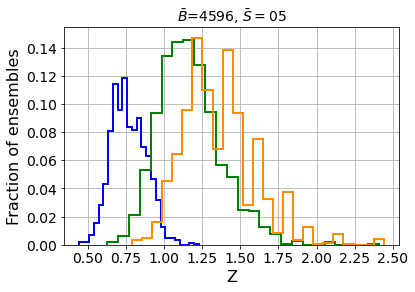

Z_bins_16bins:  0.752913061224837
Z_bins_16bins_std:  0.11084595808728277
Z_bins_50bins:  1.1586930534490913
Z_bins_50bins_std:  0.2023710187343404
Z_bins_100bins:  1.3303080794300066
Z_bins_100bins_std:  0.23952659768823245

 -------------------------------- 

B_expected:  4596
S_expected:  6
S/$\sqrt{B}$:  0.08850366191476915

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



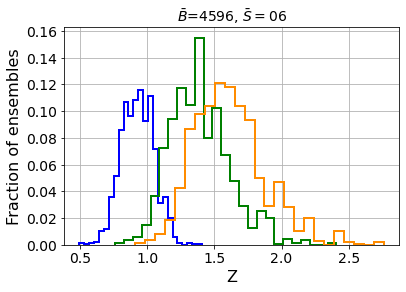

Z_bins_16bins:  0.9290104684360085
Z_bins_16bins_std:  0.11926943021361691
Z_bins_50bins:  1.368916532108942
Z_bins_50bins_std:  0.22710090771606703
Z_bins_100bins:  1.5900827264639785
Z_bins_100bins_std:  0.27121973317768855

 -------------------------------- 

B_expected:  4596
S_expected:  7
S/$\sqrt{B}$:  0.10325427223389734

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



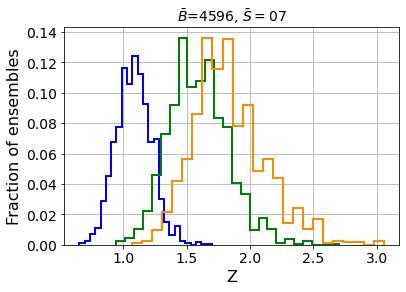

Z_bins_16bins:  1.0776849064568526
Z_bins_16bins_std:  0.13878923554325504
Z_bins_50bins:  1.5933024786532177
Z_bins_50bins_std:  0.23616422459498645
Z_bins_100bins:  1.8015721145886223
Z_bins_100bins_std:  0.2845790764599749

 -------------------------------- 

B_expected:  4596
S_expected:  8
S/$\sqrt{B}$:  0.11800488255302553

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



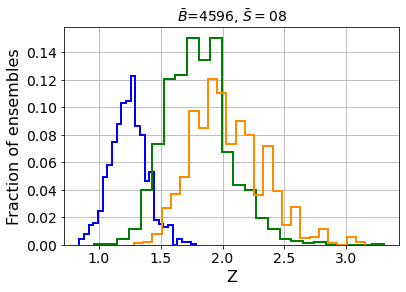

Z_bins_16bins:  1.243867421738088
Z_bins_16bins_std:  0.14474646130305313
Z_bins_50bins:  1.7779102200685917
Z_bins_50bins_std:  0.25358966137660255
Z_bins_100bins:  2.014431240868883
Z_bins_100bins_std:  0.2955207312399885

 -------------------------------- 

B_expected:  4596
S_expected:  10
S/$\sqrt{B}$:  0.1475061031912819

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



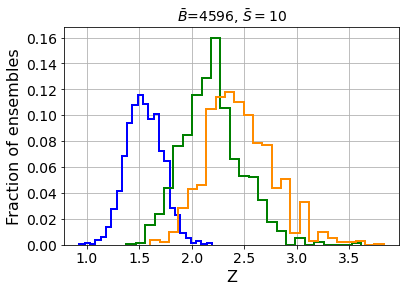

Z_bins_16bins:  1.551706088214386
Z_bins_16bins_std:  0.16907400217698826
Z_bins_50bins:  2.1922382858171785
Z_bins_50bins_std:  0.2809228609954772
Z_bins_100bins:  2.4276277737116825
Z_bins_100bins_std:  0.3186126645818233

 -------------------------------- 



In [26]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_Z_bins_XG_16bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_Z_bins_XG_16bins_std = []
store_Z_bins_XG_50bins_std = []
store_Z_bins_XG_100bins_std = []

# store_Z_bins_XG_16bins_noUnc = []
# store_Z_bins_XG_50bins_noUnc = []
# store_Z_bins_XG_100bins_noUnc = []

# store_Z_bins_XG_16bins_noUnc_std = []
# store_Z_bins_XG_50bins_noUnc_std = []
# store_Z_bins_XG_100bins_noUnc_std = []


indices_B = [i for i in range(len(pred_XG_SM))]
indices_S = [i for i in range(len(pred_XG_NP))]



#################
# Uncertainties #
#################
# Les't use an integer number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_events_back = N_ensembles_back * B_expected

# Let's find out the expected number of B and S events in each bin:

# 16 bins #

# (upB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMupB], bins=(16), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_upB = hist_back.T.ravel()/N_ensembles_back

# (downB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMdownB], bins=(16), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_downB = hist_back.T.ravel()/N_ensembles_back

back_prom_sig_16bins = abs(back_prom_upB-back_prom_downB)/2
# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
# find the minimum
back_prom_sig_16bins_noceros = []
for i in range(len(back_prom_sig_16bins)):
    if back_prom_sig_16bins[i]!=0:
        back_prom_sig_16bins_noceros.append(back_prom_sig_16bins[i])

min_back = min(back_prom_sig_16bins_noceros)

# replace the zeros
for i in range(len(back_prom_sig_16bins)):
    if back_prom_sig_16bins[i]==0:
        back_prom_sig_16bins[i] = min_back
        
        
        
# 50 bins #

# (upB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMupB], bins=(50), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_upB = hist_back.T.ravel()/N_ensembles_back

# (downB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMdownB], bins=(50), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_downB = hist_back.T.ravel()/N_ensembles_back

back_prom_sig_50bins = abs(back_prom_upB-back_prom_downB)/2
# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
# find the minimum
back_prom_sig_50bins_noceros = []
for i in range(len(back_prom_sig_50bins)):
    if back_prom_sig_50bins[i]!=0:
        back_prom_sig_50bins_noceros.append(back_prom_sig_50bins[i])

min_back = min(back_prom_sig_50bins_noceros)

# replace the zeros
for i in range(len(back_prom_sig_50bins)):
    if back_prom_sig_50bins[i]==0:
        back_prom_sig_50bins[i] = min_back
        
        
        
        
# 100 bins #

# (upB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMupB], bins=(100), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_upB = hist_back.T.ravel()/N_ensembles_back

# (downB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMdownB], bins=(100), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_downB = hist_back.T.ravel()/N_ensembles_back

back_prom_sig_100bins = abs(back_prom_upB-back_prom_downB)/2
# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
# find the minimum
back_prom_sig_100bins_noceros = []
for i in range(len(back_prom_sig_100bins)):
    if back_prom_sig_100bins[i]!=0:
        back_prom_sig_100bins_noceros.append(back_prom_sig_100bins[i])

min_back = min(back_prom_sig_100bins_noceros)

# replace the zeros
for i in range(len(back_prom_sig_100bins)):
    if back_prom_sig_100bins[i]==0:
        back_prom_sig_100bins[i] = min_back








for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    
    print('\n This may take a bit... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    Z_bins_16bins_aux = []
    Z_bins_50bins_aux = []
    Z_bins_100bins_aux = []
    
#     Z_bins_16bins_noUnc_aux = []
#     Z_bins_50bins_noUnc_aux = []
#     Z_bins_100bins_noUnc_aux = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            ran_ind_B = np.random.choice(indices_B, list_B_per_ensembles[bb])
            ran_ind_S = np.random.choice(indices_S, list_S_per_ensembles[bb])
            
            # estimate the variance in each bin as ~ (upB - downB)/2 
            
            pred_XG_SM_shuf = []
            
            pred_XG_NP_shuf = []
            
            for ill in ran_ind_B:
                pred_XG_SM_shuf.append(pred_XG_SM[ill])
                
            for ill in ran_ind_S:
                pred_XG_NP_shuf.append(pred_XG_NP[ill])
                
            
            
            ############
            # 16 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:       

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(16), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(16), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
#             ## then the signif Z^binned-Asimov without uncertainties:
#             Z_bins_16bins_noUnc = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

#             Z_bins_16bins_noUnc_aux.append(Z_bins_16bins_noUnc)
                    

            # then the signif Z^binned-Asimov with uncertainties in the background:

            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_16bins**2))/((back_prom_sig_16bins**2)+back_prom) ))**0.5 )

            Z_bins_16bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(back_prom_sig_16bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_16bins**2))) ) + sig_prom ) )**0.5

            Z_bins_16bins_aux.append(Z_bins_16bins_sig)
            
            
            
            
            
            ############
            # 50 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(50), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(50), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
#             ## then the signif Z^binned-Asimov without uncertainties:
#             Z_bins_50bins_noUnc = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

#             Z_bins_50bins_noUnc_aux.append(Z_bins_50bins_noUnc)
                    

            # then the signif Z^binned-Asimov with uncertainties in the background:

            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_50bins**2))/((back_prom_sig_50bins**2)+back_prom) ))**0.5 )

            Z_bins_50bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(back_prom_sig_50bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_50bins**2))) ) + sig_prom ) )**0.5

            Z_bins_50bins_aux.append(Z_bins_50bins_sig)
        
        
        
        
        
        
            ############
            # 100 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(100), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(100), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
#             ## then the signif Z^binned-Asimov without uncertainties:
#             Z_bins_100bins_noUnc = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

#             Z_bins_100bins_noUnc_aux.append(Z_bins_100bins_noUnc)
                    

            # then the signif Z^binned-Asimov with uncertainties in the background:

            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_100bins**2))/((back_prom_sig_100bins**2)+back_prom) ))**0.5 )

            Z_bins_100bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(back_prom_sig_100bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_100bins**2))) ) + sig_prom ) )**0.5

            Z_bins_100bins_aux.append(Z_bins_100bins_sig)
            
    
    
    
  
    # Histogram of q_muhats

    weights = np.ones_like(Z_bins_16bins_aux)/float(len(Z_bins_16bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_16bins_aux, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    weights = np.ones_like(Z_bins_50bins_aux)/float(len(Z_bins_50bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_50bins_aux, 25, weights=weights, histtype='step', color='green', linewidth=2)
    weights = np.ones_like(Z_bins_100bins_aux)/float(len(Z_bins_100bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_100bins_aux, 25, weights=weights, histtype='step', color='darkorange', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Z",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()
    
    
    # 16 bins #
    # Remove nan if any
    Z_bins_16bins_aux = [x for x in Z_bins_16bins_aux if x == x]
    for jk in range(len(Z_bins_16bins_aux)):
        if Z_bins_16bins_aux[jk] < 0:
            Z_bins_16bins_aux[jk] = 0

    Z_bins_16bins = np.median(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins.append(Z_bins_16bins)
    
    Z_bins_16bins_std = np.std(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins_std.append(Z_bins_16bins_std)

    print('Z_bins_16bins: ', Z_bins_16bins)
    print('Z_bins_16bins_std: ', Z_bins_16bins_std)

    
#     # Remove nan if any
#     Z_bins_16bins_noUnc_aux = [x for x in Z_bins_16bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_16bins_noUnc_aux)):
#         if Z_bins_16bins_noUnc_aux[jk] < 0:
#             Z_bins_16bins_noUnc_aux[jk] = 0

#     Z_bins_16bins_noUnc = np.median(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc.append(Z_bins_16bins_noUnc)
    
#     Z_bins_16bins_noUnc_std = np.std(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc_std.append(Z_bins_16bins_noUnc_std)

#     print('Z_bins_16bins_noUnc: ', Z_bins_16bins_noUnc)
#     print('Z_bins_16bins_noUnc_std: ', Z_bins_16bins_noUnc_std)
    
    
    # 50 bins #
    # Remove nan if any
    Z_bins_50bins_aux = [x for x in Z_bins_50bins_aux if x == x]
    for jk in range(len(Z_bins_50bins_aux)):
        if Z_bins_50bins_aux[jk] < 0:
            Z_bins_50bins_aux[jk] = 0

    Z_bins_50bins = np.median(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins.append(Z_bins_50bins)
    
    Z_bins_50bins_std = np.std(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins_std.append(Z_bins_50bins_std)

    print('Z_bins_50bins: ', Z_bins_50bins)
    print('Z_bins_50bins_std: ', Z_bins_50bins_std)
    
    
#     # Remove nan if any
#     Z_bins_50bins_noUnc_aux = [x for x in Z_bins_50bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_50bins_noUnc_aux)):
#         if Z_bins_50bins_noUnc_aux[jk] < 0:
#             Z_bins_50bins_noUnc_aux[jk] = 0

#     Z_bins_50bins_noUnc = np.median(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc.append(Z_bins_50bins_noUnc)
    
#     Z_bins_50bins_noUnc_std = np.std(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc_std.append(Z_bins_50bins_noUnc_std)

#     print('Z_bins_50bins_noUnc: ', Z_bins_50bins_noUnc)
#     print('Z_bins_50bins_noUnc_std: ', Z_bins_50bins_noUnc_std)
    
    
    # 100 bins #
    # Remove nan if any
    Z_bins_100bins_aux = [x for x in Z_bins_100bins_aux if x == x]
    for jk in range(len(Z_bins_100bins_aux)):
        if Z_bins_100bins_aux[jk] < 0:
            Z_bins_100bins_aux[jk] = 0

    Z_bins_100bins = np.median(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins.append(Z_bins_100bins)
    
    Z_bins_100bins_std = np.std(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins_std.append(Z_bins_100bins_std)

    print('Z_bins_100bins: ', Z_bins_100bins)
    print('Z_bins_100bins_std: ', Z_bins_100bins_std)
    
    
#     # Remove nan if any
#     Z_bins_100bins_noUnc_aux = [x for x in Z_bins_100bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_100bins_noUnc_aux)):
#         if Z_bins_100bins_noUnc_aux[jk] < 0:
#             Z_bins_100bins_noUnc_aux[jk] = 0

#     Z_bins_100bins_noUnc = np.median(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc.append(Z_bins_100bins_noUnc)
    
#     Z_bins_100bins_noUnc_std = np.std(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc_std.append(Z_bins_100bins_noUnc_std)

#     print('Z_bins_100bins_noUnc: ', Z_bins_100bins_noUnc)
#     print('Z_bins_100bins_noUnc_std: ', Z_bins_100bins_noUnc_std)

    print('\n -------------------------------- \n')

In [27]:
print(store_Z_bins_XG_16bins)
print(store_Z_bins_XG_50bins)
print(store_Z_bins_XG_100bins)

print(store_Z_bins_XG_16bins_std)
print(store_Z_bins_XG_50bins_std)
print(store_Z_bins_XG_100bins_std)

[0.15352471969283446, 0.31179238702983436, 0.42385805944799465, 0.591219268143734, 0.752913061224837, 0.9290104684360085, 1.0776849064568526, 1.243867421738088, 1.551706088214386]
[0.22206979064183224, 0.46842217534975594, 0.691982906061105, 0.9365345489293795, 1.1586930534490913, 1.368916532108942, 1.5933024786532177, 1.7779102200685917, 2.1922382858171785]
[0.2613006467800254, 0.5719070269289, 0.8376335649697051, 1.083004088109154, 1.3303080794300066, 1.5900827264639785, 1.8015721145886223, 2.014431240868883, 2.4276277737116825]
[0.09609887323686536, 0.09051330340176694, 0.09230142824383611, 0.09841034009482212, 0.11084595808728277, 0.11926943021361691, 0.13878923554325504, 0.14474646130305313, 0.16907400217698826]
[0.16803833797463016, 0.15602170015630026, 0.15721308435244719, 0.1782899403065825, 0.2023710187343404, 0.22710090771606703, 0.23616422459498645, 0.25358966137660255, 0.2809228609954772]
[0.21866995820218307, 0.1919689506499189, 0.20160726085188777, 0.2227574289295603, 0.2

In [24]:
store_Z_bins_XG_16bins = [0.15352471969283446, 0.31179238702983436, 0.42385805944799465, 0.591219268143734, 0.752913061224837, 0.9290104684360085, 1.0776849064568526, 1.243867421738088, 1.551706088214386]
store_Z_bins_XG_50bins = [0.22206979064183224, 0.46842217534975594, 0.691982906061105, 0.9365345489293795, 1.1586930534490913, 1.368916532108942, 1.5933024786532177, 1.7779102200685917, 2.1922382858171785]
store_Z_bins_XG_100bins = [0.2613006467800254, 0.5719070269289, 0.8376335649697051, 1.083004088109154, 1.3303080794300066, 1.5900827264639785, 1.8015721145886223, 2.014431240868883, 2.4276277737116825]

store_Z_bins_XG_16bins_std = [0.09609887323686536, 0.09051330340176694, 0.09230142824383611, 0.09841034009482212, 0.11084595808728277, 0.11926943021361691, 0.13878923554325504, 0.14474646130305313, 0.16907400217698826]
store_Z_bins_XG_50bins_std = [0.16803833797463016, 0.15602170015630026, 0.15721308435244719, 0.1782899403065825, 0.2023710187343404, 0.22710090771606703, 0.23616422459498645, 0.25358966137660255, 0.2809228609954772]
store_Z_bins_XG_100bins_std =[0.21866995820218307, 0.1919689506499189, 0.20160726085188777, 0.2227574289295603, 0.23952659768823245, 0.27121973317768855, 0.2845790764599749, 0.2955207312399885, 0.3186126645818233]

B_expected:  4596
S_expected:  1
S/$\sqrt{B}$:  0.014750610319128192


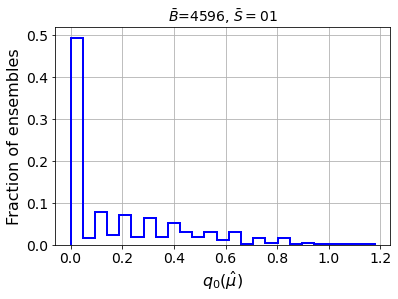

bins:  16
muhat mean:  -0.11752878258874215
median q_muhat_16bins:  0.05591897255496647
Z_16bins:  0.23647192762559888
Z_16bins mu=0:  0.23647192762559888
std Z_16bins:  0.5097108918550999
std Z_16bins mu=0:  0.5099108481018783


 -------------------------------- 

B_expected:  4596
S_expected:  2
S/$\sqrt{B}$:  0.029501220638256383


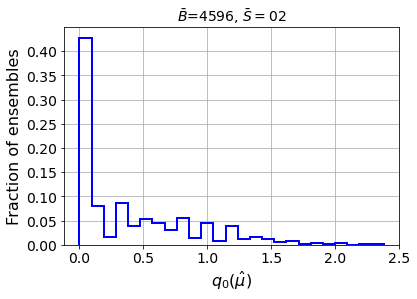

bins:  16
muhat mean:  -0.03416654509967107
median q_muhat_16bins:  0.17382960958969917
Z_16bins:  0.41692878239538606
Z_16bins mu=0:  0.41692878239538606
std Z_16bins:  0.5637850426948764
std Z_16bins mu=0:  0.5661193631775531


 -------------------------------- 

B_expected:  4596
S_expected:  3
S/$\sqrt{B}$:  0.04425183095738457


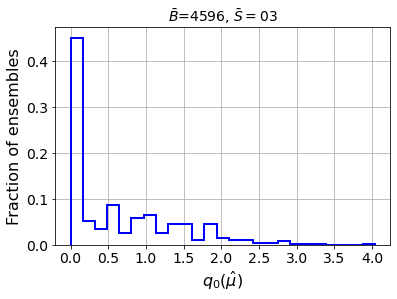

bins:  16
muhat mean:  0.05602664683330531
median q_muhat_16bins:  0.3189939630848624
Z_16bins:  0.5647955055459121
Z_16bins mu=0:  0.5643067025235365
std Z_16bins:  0.6444969418566797
std Z_16bins mu=0:  0.6499733531928479


 -------------------------------- 

B_expected:  4596
S_expected:  4
S/$\sqrt{B}$:  0.05900244127651277


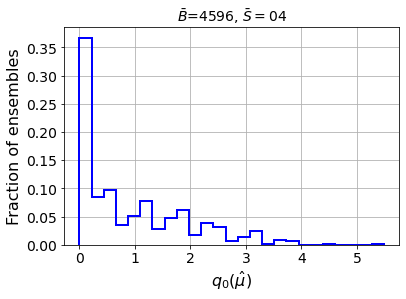

bins:  16
muhat mean:  0.05708518915694725
median q_muhat_16bins:  0.5640803479017418
Z_16bins:  0.7510528263056746
Z_16bins mu=0:  0.7506979255966444
std Z_16bins:  0.6571872730895327
std Z_16bins mu=0:  0.6643353158480235


 -------------------------------- 

B_expected:  4596
S_expected:  5
S/$\sqrt{B}$:  0.07375305159564095


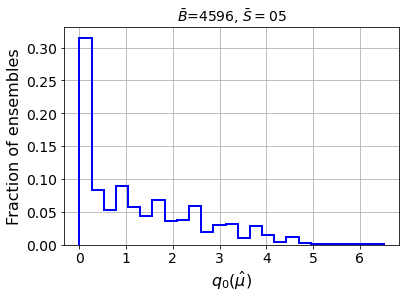

bins:  16
muhat mean:  0.030664149176918395
median q_muhat_16bins:  0.8797947974499589
Z_16bins:  0.9379737722612285
Z_16bins mu=0:  0.9378035166152172
std Z_16bins:  0.6776699402235795
std Z_16bins mu=0:  0.6900174630518378


 -------------------------------- 

B_expected:  4596
S_expected:  6
S/$\sqrt{B}$:  0.08850366191476915


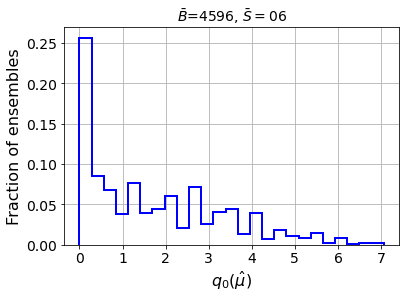

bins:  16
muhat mean:  -0.01265576297604412
median q_muhat_16bins:  1.3051866212158139
Z_16bins:  1.1424476448467185
Z_16bins mu=0:  1.1424476448467185
std Z_16bins:  0.6957113829574011
std Z_16bins mu=0:  0.7118344277708798


 -------------------------------- 

B_expected:  4596
S_expected:  7
S/$\sqrt{B}$:  0.10325427223389734


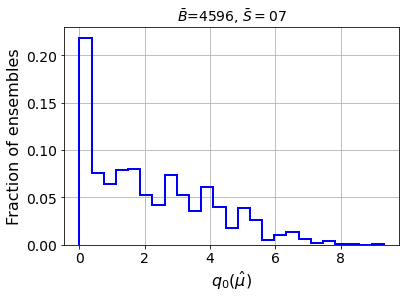

bins:  16
muhat mean:  -0.008881596634534344
median q_muhat_16bins:  1.7540950080421238
Z_16bins:  1.3244225187009333
Z_16bins mu=0:  1.3244225187009333
std Z_16bins:  0.7030363348646207
std Z_16bins mu=0:  0.7233301518003764


 -------------------------------- 

B_expected:  4596
S_expected:  8
S/$\sqrt{B}$:  0.11800488255302553


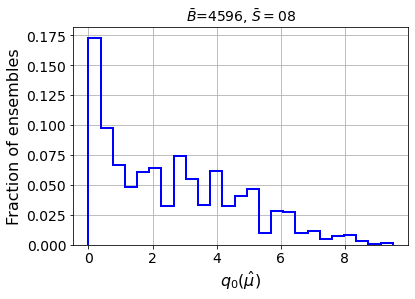

bins:  16
muhat mean:  0.010770274550563905
median q_muhat_16bins:  2.1934496959167955
Z_16bins:  1.4810299443011932
Z_16bins mu=0:  1.4810299443011932
std Z_16bins:  0.7191763183134285
std Z_16bins mu=0:  0.748142153910316


 -------------------------------- 

B_expected:  4596
S_expected:  10
S/$\sqrt{B}$:  0.1475061031912819


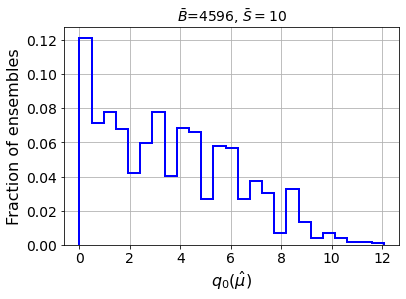

bins:  16
muhat mean:  0.019351424616298532
median q_muhat_16bins:  3.255890039532371
Z_16bins:  1.8044085012913154
Z_16bins mu=0:  1.8044083599756002
std Z_16bins:  0.7233564504463376
std Z_16bins mu=0:  0.7642777561142556


 -------------------------------- 

[-0.11752878258874215, -0.03416654509967107, 0.05602664683330531, 0.05708518915694725, 0.030664149176918395, -0.01265576297604412, -0.008881596634534344, 0.010770274550563905, 0.019351424616298532]
[0.23647192762559888, 0.41692878239538606, 0.5647955055459121, 0.7510528263056746, 0.9379737722612285, 1.1424476448467185, 1.3244225187009333, 1.4810299443011932, 1.8044085012913154]
[0.5097108918550999, 0.5637850426948764, 0.6444969418566797, 0.6571872730895327, 0.6776699402235795, 0.6957113829574011, 0.7030363348646207, 0.7191763183134285, 0.7233564504463376]
[0.23647192762559888, 0.41692878239538606, 0.5643067025235365, 0.7506979255966444, 0.9378035166152172, 1.1424476448467185, 1.3244225187009333, 1.4810299443011932, 1.80440835997

In [25]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_muhat_mean_16bins  = []

store_Z_bins_XG_16bins_q = []
store_Z_bins_XG_16bins_std = []

store_Z_bins_XG_16bins_mu0 = []
store_Z_bins_XG_16bins_std_mu0 = []




hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(16), range = [[0,1]])
bin_edges = binedges_back[0]
back_prom_16bins = hist_back.T.ravel() / (len(pred_XG_SM) / B_expected)

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom_16bins)):
    if back_prom_16bins[i]!=0:
        back_prom_noceros.append(back_prom_16bins[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom_16bins)):
    if back_prom_16bins[i]==0:
        back_prom_16bins[i] = min_back
        
        






for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    

    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(16), range = [[0,1]])
    sig_prom_16bins = hist_sig.T.ravel() / (len(pred_XG_NP) / S_expected[iii])
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_16bins_list = []
    q_muhat_16bins = []
    q_muhat_16bins_mu0 = []
    
    
    for its in range(n_ensembles):
        
        B_rand = np.random.poisson(int(B_expected))
        
        pred_XG_SM_shuf = np.random.choice(pred_XG_SM, size = B_rand, replace = False)
            
        pseudo_exp = pred_XG_SM_shuf


        ############
        # 16 bins #
        ############

        # Let's find out the expected number of B and S events in each bin:

        # bin the parameter space of all background events
        hist_N, binedges_N = np.histogramdd([pseudo_exp], bins=(16), range = [[0,1]])
        # now divide by the number of possible ensembles
        N_pseudo = hist_N.T.ravel()

        if min(N_pseudo) >= MIN_EVS:
                
            # approximation: mu_hat=0
            q_muhat_16bins_mu0.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((0.*si)+bi) ) ) - ((1.*si)+bi) + ((0.*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

                
            # compute mu_hat from implicit equation
            def f_mu_hat(mu_h, N_pseudo=N_pseudo, sig_prom_16bins=sig_prom_16bins, back_prom_16bins=back_prom_16bins):
                return sum ( [((ni*si) / ((mu_h*si) + bi)) - si for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)] )

        
            muhat_selected_16bins = fsolve(f_mu_hat,0)[0]
            
            muhat_selected_16bins_list.append(muhat_selected_16bins)

                
            if muhat_selected_16bins > 1:
                q_muhat_16bins.append( 0 )
                    
            elif muhat_selected_16bins > 0:
                q_muhat_16bins.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((muhat_selected_16bins*si)+bi) ) ) - ((1.*si)+bi) + ((muhat_selected_16bins*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

            else:
                q_muhat_16bins.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((0.*si)+bi) ) ) - ((1.*si)+bi) + ((0.*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

            
            
            
        
        
    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_16bins)/float(len(q_muhat_16bins))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_16bins, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()

    
    

    # Finally calculate muhat_mean and Z_gaussian
    
    # 16 bins #
    # Remove nan if any
    q_muhat_16bins_mu0 = [x for x in q_muhat_16bins_mu0 if x == x]
    for jk in range(len(q_muhat_16bins_mu0)):
        if q_muhat_16bins_mu0[jk] < 0:
            q_muhat_16bins_mu0[jk] = 0

    q_muhat_16bins_median_mu0 = np.median(q_muhat_16bins_mu0)
    Z_16bins_mu0 = abs(q_muhat_16bins_median_mu0)**0.5
    store_Z_bins_XG_16bins_mu0.append(Z_16bins_mu0)
    
    q_muhat_16bins_std_mu0 = np.std(q_muhat_16bins_mu0)
    Z_16bins_std_mu0 = q_muhat_16bins_std_mu0/(2.*Z_16bins_mu0)
    store_Z_bins_XG_16bins_std_mu0.append(Z_16bins_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_16bins = np.mean(muhat_selected_16bins_list)
    store_muhat_mean_16bins.append(muhat_mean_16bins)

    # Remove nan if any
    q_muhat_16bins = [x for x in q_muhat_16bins if x == x]
    for jk in range(len(q_muhat_16bins)):
        if q_muhat_16bins[jk] < 0:
            q_muhat_16bins[jk] = 0

    q_muhat_16bins_median = np.median(q_muhat_16bins)
    Z_16bins = abs(q_muhat_16bins_median)**0.5
    store_Z_bins_XG_16bins_q.append(Z_16bins)
    
    q_muhat_16bins_std = np.std(q_muhat_16bins)
    Z_16bins_std = q_muhat_16bins_std/(2.*Z_16bins)
    store_Z_bins_XG_16bins_std.append(Z_16bins_std)

    print('bins: ', 16)
    print('muhat mean: ', muhat_mean_16bins)
    print('median q_muhat_16bins: ', q_muhat_16bins_median)
    print('Z_16bins: ', Z_16bins)
    print('Z_16bins mu=0: ', Z_16bins_mu0)
    print('std Z_16bins: ', Z_16bins_std)
    print('std Z_16bins mu=0: ', Z_16bins_std_mu0)
    print('')
    
    

    print('\n -------------------------------- \n')
    

print(store_muhat_mean_16bins)

print(store_Z_bins_XG_16bins_q)
print(store_Z_bins_XG_16bins_std)

print(store_Z_bins_XG_16bins_mu0)
print(store_Z_bins_XG_16bins_std_mu0)

In [28]:
store_muhat_mean_16bins = [-0.11752878258874215, -0.03416654509967107, 0.05602664683330531, 0.05708518915694725, 0.030664149176918395, -0.01265576297604412, -0.008881596634534344, 0.010770274550563905, 0.019351424616298532]

store_Z_bins_XG_16bins_q = [0.23647192762559888, 0.41692878239538606, 0.5647955055459121, 0.7510528263056746, 0.9379737722612285, 1.1424476448467185, 1.3244225187009333, 1.4810299443011932, 1.8044085012913154]
store_Z_bins_XG_16bins_std = [0.5097108918550999, 0.5637850426948764, 0.6444969418566797, 0.6571872730895327, 0.6776699402235795, 0.6957113829574011, 0.7030363348646207, 0.7191763183134285, 0.7233564504463376]

store_Z_bins_XG_16bins_mu0 = [0.23647192762559888, 0.41692878239538606, 0.5643067025235365, 0.7506979255966444, 0.9378035166152172, 1.1424476448467185, 1.3244225187009333, 1.4810299443011932, 1.8044083599756002]
store_Z_bins_XG_16bins_std_mu0 = [0.5099108481018783, 0.5661193631775531, 0.6499733531928479, 0.6643353158480235, 0.6900174630518378, 0.7118344277708798, 0.7233301518003764, 0.748142153910316, 0.7642777561142556]

In [26]:
store_Z_bins_XG_16bins_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]
store_Z_bins_XG_16bins_min = [i-j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]

store_Z_bins_XG_50bins_plus = [i+j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]
store_Z_bins_XG_50bins_min = [i-j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]

store_Z_bins_XG_100bins_plus = [i+j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]
store_Z_bins_XG_100bins_min = [i-j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]

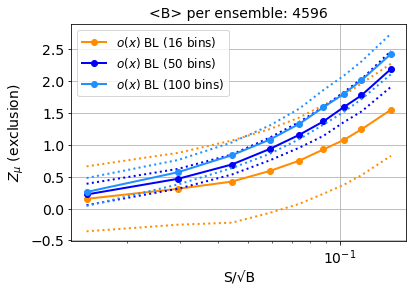

In [27]:
#########
# PLOTS #
#########

posX = []

for i in range(len(S_expected)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### MLL KDE

#### KDE

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf 14140.68140204 12897.2395544  11535.02293203
 10079.03088753  8543.24997451  6941.20461397  5282.81686986
  3563.14896335  1811.19732012    42.75208366 -1710.41270089]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


Background:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf 13805.02273325 12629.73125181 11337.53596404
  9928.72910632  8433.89306039  6874.81560952  5239.98041753
  3552.64581293  1814.90022294    41.49440864 -1706.53492995]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


Signal:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


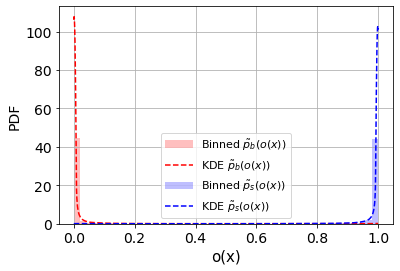

In [30]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

#SM_bandwidth = 0.0127
#NP_bandwidth = 0.0127

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

B_expected:  4596


<ipython-input-31-f9ea0c121e56>:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
<ipython-input-31-f9ea0c121e56>:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
<ipython-input-31-f9ea0c121e56>:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)')


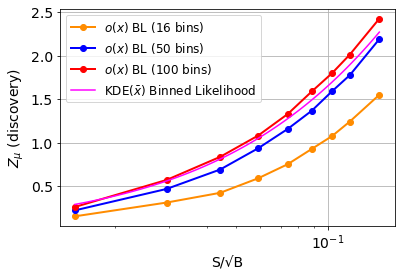

In [31]:
# We can do a quick Z bin-loglikelihood calculation using the computed KDE
# this is to check the KDE here, because we use KDE to avoid binning


# in each ensemble we use B=50k
print('B_expected: ', B_expected)

# values of S / sqrt{B} to test 
soversqrtB = np.linspace(SsqrtB[0],SsqrtB[-1],100)



# Let's find out the expected number of B and S events in each bin:

# total number of B * B_pdf value in each bin * bin size
Bd = B_expected*dens_bkg*(s_vals[1]-s_vals[0])



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
Bd_noceros = []
for i in range(len(Bd)):
    if Bd[i]!=0:
        Bd_noceros.append(Bd[i])

min_back = min(Bd_noceros)

# replace the zeros
for i in range(len(Bd)):
    if Bd[i]==0:
        Bd[i] = min_back




# Now calculate Z using the Binned Likelihood formula

Zvals = np.zeros(len(soversqrtB))

for nval, val in enumerate(soversqrtB):
    # S events in each bin: 
    # value of S/sqrt{B} * sqrt{B} * S_pdf value in each bin * bin size
    Sd = val*np.sqrt(B_expected)*dens_sig*(s_vals[1]-s_vals[0])
    
    # Z value:
    #Zvals[nval]= np.sqrt(2.0*np.sum(((Sd+Bd)*np.log(1.0+Sd/Bd)-Sd))) # Discovery
    Zvals[nval]= np.sqrt(2.0*np.sum(Bd*np.log(Bd/(Sd+Bd))+Sd)) # Exclusion

    
    
    
# PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(soversqrtB, Zvals, color='magenta', label=r'KDE$(\bar{x})$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

#### MLL KDE

In [32]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

In [33]:
#################################################
# Uncertainties in tau pT using the dataset upB #
#################################################

KDE_SM_pred_SMupB = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SMupB, np.zeros(len(pred_XG_SMupB)) ]) )
KDE_NP_pred_SMupB = np.exp(kde_sig.score_samples(np.c_[pred_XG_SMupB, np.ones(len(pred_XG_SMupB)) ]) )


# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SMupB / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SMupB / factor_aux_NP

B_expected:  4596
S_expected:  1
S/$\sqrt{B}$:  0.014750610319128192
n_ensembles (initial):  2000

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



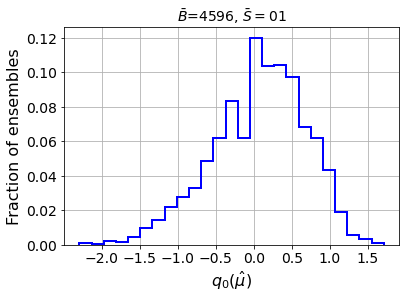

muhat mean:  0.05599662162162163
median q_muhat_KDE:  0.12436200179462997
Z_KDE:  0.3526499706431719
Z_KDE mu=0:  0.3526499706431719
std Z_KDE:  0.4899779547975705
std Z_KDE mu=0:  0.49112294759131436

 -------------------------------- 

B_expected:  4596
S_expected:  2
S/$\sqrt{B}$:  0.029501220638256383
n_ensembles (initial):  2000

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



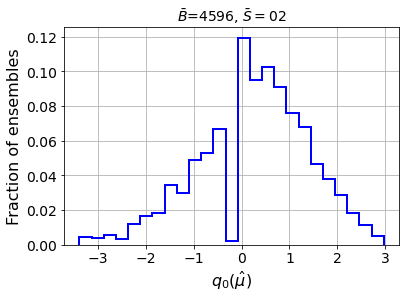

muhat mean:  0.09028716216216218
median q_muhat_KDE:  0.39802622075733973
Z_KDE:  0.6308931928285006
Z_KDE mu=0:  0.6308931928285006
std Z_KDE:  0.5569302004463426
std Z_KDE mu=0:  0.5606198740443918

 -------------------------------- 

B_expected:  4596
S_expected:  3
S/$\sqrt{B}$:  0.04425183095738457
n_ensembles (initial):  2000

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



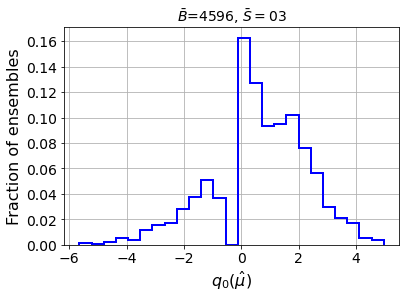

muhat mean:  0.1325168918918919
median q_muhat_KDE:  0.720010193356484
Z_KDE:  0.8485341438955087
Z_KDE mu=0:  0.8482878610948541
std Z_KDE:  0.6465400708522216
std Z_KDE mu=0:  0.6568867667872018

 -------------------------------- 

B_expected:  4596
S_expected:  4
S/$\sqrt{B}$:  0.05900244127651277
n_ensembles (initial):  2000

 If  920  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



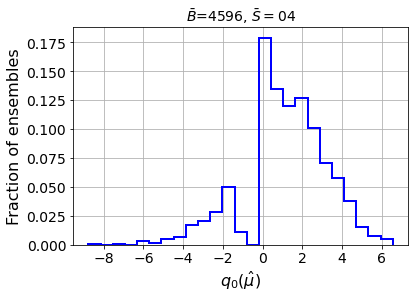

muhat mean:  0.15782657657657662
median q_muhat_KDE:  1.2511804794759023
Z_KDE:  1.118561790638274
Z_KDE mu=0:  1.1193269763301779
std Z_KDE:  0.6535129741509255
std Z_KDE mu=0:  0.6688576715470765

 -------------------------------- 

B_expected:  4596
S_expected:  5
S/$\sqrt{B}$:  0.07375305159564095
n_ensembles (initial):  2000

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



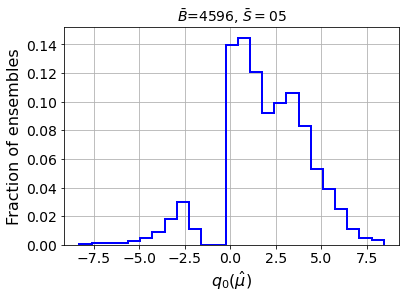

muhat mean:  0.1744650900900901
median q_muhat_KDE:  1.839707795937119
Z_KDE:  1.356358284501967
Z_KDE mu=0:  1.3555159734099034
std Z_KDE:  0.6830954127916729
std Z_KDE mu=0:  0.7089737970197354

 -------------------------------- 

B_expected:  4596
S_expected:  6
S/$\sqrt{B}$:  0.08850366191476915
n_ensembles (initial):  2000

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



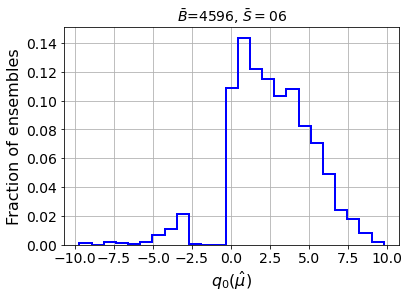

muhat mean:  0.17798423423423423
median q_muhat_KDE:  2.5025708091774606
Z_KDE:  1.5819515824378003
Z_KDE mu=0:  1.5829953085703357
std Z_KDE:  0.6842240516326646
std Z_KDE mu=0:  0.7177269883038323

 -------------------------------- 

B_expected:  4596
S_expected:  7
S/$\sqrt{B}$:  0.10325427223389734
n_ensembles (initial):  2000

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



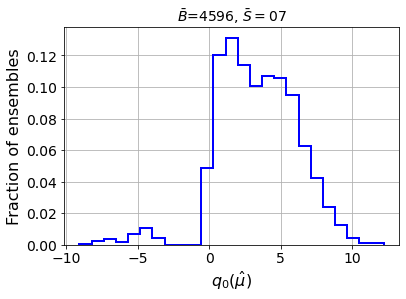

muhat mean:  0.16480855855855855
median q_muhat_KDE:  3.295793520257992
Z_KDE:  1.8154320478216726
Z_KDE mu=0:  1.815112107364749
std Z_KDE:  0.6682769672170706
std Z_KDE mu=0:  0.711138908238349

 -------------------------------- 

B_expected:  4596
S_expected:  8
S/$\sqrt{B}$:  0.11800488255302553
n_ensembles (initial):  2000

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



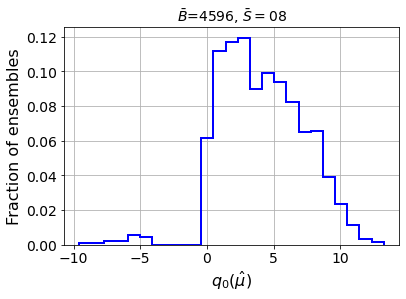

muhat mean:  0.17119932432432436
median q_muhat_KDE:  3.871873388677834
Z_KDE:  1.967707648172826
Z_KDE mu=0:  1.9679373978218455
std Z_KDE:  0.7279239563492955
std Z_KDE mu=0:  0.7804906036667485

 -------------------------------- 

B_expected:  4596
S_expected:  10
S/$\sqrt{B}$:  0.1475061031912819
n_ensembles (initial):  2000

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



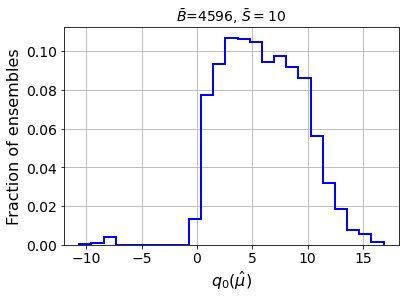

muhat mean:  0.14487612612612613
median q_muhat_KDE:  5.794617644944889
Z_KDE:  2.4072012057459777
Z_KDE mu=0:  2.4072012057459777
std Z_KDE:  0.7165315725254962
std Z_KDE mu=0:  0.7838993136480533

 -------------------------------- 



In [34]:
store_muhat_mean_MLL_KDE = []

store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_std_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break


            muhat_selected_KDE_list.append(muhat_selected_KDE)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    
    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    
    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')

In [35]:
print(store_muhat_mean_MLL_KDE)

print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

print(store_Z_MLL_KDE_std)
print(store_Z_MLL_KDE_std_mu0)

[0.05599662162162163, 0.09028716216216218, 0.1325168918918919, 0.15782657657657662, 0.1744650900900901, 0.17798423423423423, 0.16480855855855855, 0.17119932432432436, 0.14487612612612613]
[0.3526499706431719, 0.6308931928285006, 0.8485341438955087, 1.118561790638274, 1.356358284501967, 1.5819515824378003, 1.8154320478216726, 1.967707648172826, 2.4072012057459777]
[0.3526499706431719, 0.6308931928285006, 0.8482878610948541, 1.1193269763301779, 1.3555159734099034, 1.5829953085703357, 1.815112107364749, 1.9679373978218455, 2.4072012057459777]
[0.4899779547975705, 0.5569302004463426, 0.6465400708522216, 0.6535129741509255, 0.6830954127916729, 0.6842240516326646, 0.6682769672170706, 0.7279239563492955, 0.7165315725254962]
[0.49112294759131436, 0.5606198740443918, 0.6568867667872018, 0.6688576715470765, 0.7089737970197354, 0.7177269883038323, 0.711138908238349, 0.7804906036667485, 0.7838993136480533]


In [28]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_MLL_KDE = [0.05599662162162163, 0.09028716216216218, 0.1325168918918919, 0.15782657657657662, 0.1744650900900901, 0.17798423423423423, 0.16480855855855855, 0.17119932432432436, 0.14487612612612613]

store_Z_MLL_KDE = [0.3526499706431719, 0.6308931928285006, 0.8485341438955087, 1.118561790638274, 1.356358284501967, 1.5819515824378003, 1.8154320478216726, 1.967707648172826, 2.4072012057459777]
store_Z_MLL_KDE_mu0 = [0.3526499706431719, 0.6308931928285006, 0.8482878610948541, 1.1193269763301779, 1.3555159734099034, 1.5829953085703357, 1.815112107364749, 1.9679373978218455, 2.4072012057459777]

store_Z_MLL_KDE_std = [0.4899779547975705, 0.5569302004463426, 0.6465400708522216, 0.6535129741509255, 0.6830954127916729, 0.6842240516326646, 0.6682769672170706, 0.7279239563492955, 0.7165315725254962]
store_Z_MLL_KDE_std_mu0 = [0.49112294759131436, 0.5606198740443918, 0.6568867667872018, 0.6688576715470765, 0.7089737970197354, 0.7177269883038323, 0.711138908238349, 0.7804906036667485, 0.7838993136480533]

In [29]:
store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

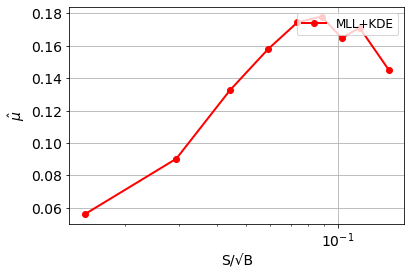

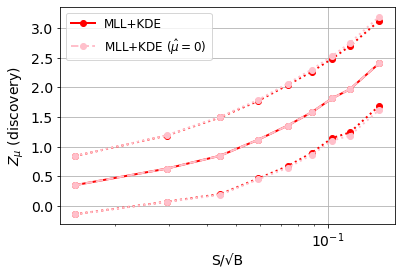

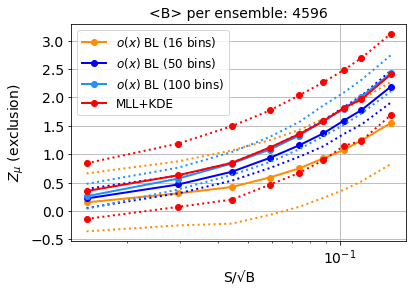

In [30]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0, '--o', color='pink', lw=lw, label=r'MLL+KDE ($\hat{\mu}=0$)')
plt.plot(posX, store_Z_MLL_KDE_mu0_plus, ':o', color='pink', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0_min, ':o', color='pink', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### Interpolate

In [31]:
# if Z < 0 -> Z=0

store_Z_bins_XG_16bins = [0 if i < 0 else i for i in store_Z_bins_XG_16bins]
store_Z_bins_XG_16bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_plus]
store_Z_bins_XG_16bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_min]

store_Z_bins_XG_50bins = [0 if i < 0 else i for i in store_Z_bins_XG_50bins]
store_Z_bins_XG_50bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_plus]
store_Z_bins_XG_50bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_min]

store_Z_bins_XG_100bins = [0 if i < 0 else i for i in store_Z_bins_XG_100bins]
store_Z_bins_XG_100bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_plus]
store_Z_bins_XG_100bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_min]

store_Z_MLL_KDE = [0 if i < 0 else i for i in store_Z_MLL_KDE]
store_Z_MLL_KDE_plus = [0 if i < 0 else i for i in store_Z_MLL_KDE_plus]
store_Z_MLL_KDE_min = [0 if i < 0 else i for i in store_Z_MLL_KDE_min]

In [32]:
# add zero

posX = [0.001] + posX

store_Z_bins_XG_16bins = [0] + store_Z_bins_XG_16bins
store_Z_bins_XG_16bins_plus = [0] + store_Z_bins_XG_16bins_plus
store_Z_bins_XG_16bins_min = [0] + store_Z_bins_XG_16bins_min

store_Z_bins_XG_50bins = [0] + store_Z_bins_XG_50bins
store_Z_bins_XG_50bins_plus = [0] + store_Z_bins_XG_50bins_plus
store_Z_bins_XG_50bins_min = [0] + store_Z_bins_XG_50bins_min

store_Z_bins_XG_100bins = [0] + store_Z_bins_XG_100bins
store_Z_bins_XG_100bins_plus = [0] + store_Z_bins_XG_100bins_plus
store_Z_bins_XG_100bins_min = [0] + store_Z_bins_XG_100bins_min

store_Z_MLL_KDE = [0] + store_Z_MLL_KDE
store_Z_MLL_KDE_plus = [0] + store_Z_MLL_KDE_plus
store_Z_MLL_KDE_min = [0] + store_Z_MLL_KDE_min

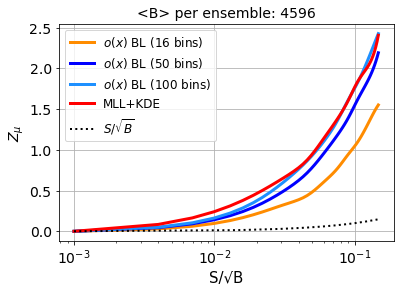

In [33]:
  
# Interpolation, cubic
f_16bins = interp1d(posX, store_Z_bins_XG_16bins, kind='cubic')
f_16bins_plus = interp1d(posX, store_Z_bins_XG_16bins_plus, kind='cubic')
f_16bins_min = interp1d(posX, store_Z_bins_XG_16bins_min, kind='cubic')

f_50bins = interp1d(posX, store_Z_bins_XG_50bins, kind='cubic')
f_50bins_plus = interp1d(posX, store_Z_bins_XG_50bins_plus, kind='cubic')
f_50bins_min = interp1d(posX, store_Z_bins_XG_50bins_min, kind='cubic')

f_100bins = interp1d(posX, store_Z_bins_XG_100bins, kind='cubic')
f_100bins_plus = interp1d(posX, store_Z_bins_XG_100bins_plus, kind='cubic')
f_100bins_min = interp1d(posX, store_Z_bins_XG_100bins_min, kind='cubic')

f_MLL_KDE = interp1d(posX, store_Z_MLL_KDE, kind='cubic')
f_MLL_KDE_plus = interp1d(posX, store_Z_MLL_KDE_plus, kind='cubic')
f_MLL_KDE_min = interp1d(posX, store_Z_MLL_KDE_min, kind='cubic')



# x to plot
plotX = np.linspace(min(posX), max(posX), num=50, endpoint=True)



plt.figure()
lw = 2

plt.plot(plotX, f_16bins(plotX), '-', color='darkorange', lw=3, label=r'$o(x)$ BL (16 bins)')
plt.plot(plotX, f_50bins(plotX), '-', color='blue', lw=3, label=r'$o(x)$ BL (50 bins)')
plt.plot(plotX, f_100bins(plotX), '-', color='dodgerblue', lw=3, label=r'$o(x)$ BL (100 bins)')
plt.plot(plotX, f_MLL_KDE(plotX), '-', color='red', lw=3, label='MLL+KDE')
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

#plt.ylim([0., 6])
#plt.xlim([0.06, 10])
#plt.ylim([0., 3])
#plt.xlim([0.1, 0.2])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=15)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [34]:
# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solve(fn, value, x=0.1, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

In [35]:
# We need the ratio of the fiducial cross-sections for different values of beta to rescale

beta = [0,0.1,0.3,0.5,0.7,0.9,1]

# m_LQ = [ 1200, 1400, 1600, 1800 ]  GeV
ind_mass = 2

fidcross_beta00 = [0.01105192, 0.0030939120000000003, 0.0010050880000000001, 0.00029555639999999996]
fidcross_beta01 = [0.0491575, 0.01736763, 0.005743949999999999, 0.0019831400000000004]
fidcross_beta03 = [0.09334300000000001, 0.030734200000000003, 0.009711, 0.00331056]
fidcross_beta05 = [0.1169796, 0.03694208, 0.01213745, 0.0041233500000000005]
fidcross_beta07 = [0.10827519999999999, 0.03488576, 0.011685379999999999, 0.004226183999999999]
fidcross_beta09 = [0.0777504, 0.02674464, 0.00962278, 0.0031703000000000005]
fidcross_beta1 = [0.0376428, 0.01194092, 0.003957376, 0.0013051116]


S00 = round(300 * crossfidNP) * (fidcross_beta00[ind_mass]/fidcross_beta05[ind_mass])
S01 = round(300 * crossfidNP) * (fidcross_beta01[ind_mass]/fidcross_beta05[ind_mass])
S03 = round(300 * crossfidNP) * (fidcross_beta03[ind_mass]/fidcross_beta05[ind_mass])
S05 = round(300 * crossfidNP) * (fidcross_beta05[ind_mass]/fidcross_beta05[ind_mass])
S07 = round(300 * crossfidNP) * (fidcross_beta07[ind_mass]/fidcross_beta05[ind_mass])
S09 = round(300 * crossfidNP) * (fidcross_beta09[ind_mass]/fidcross_beta05[ind_mass])
S1 = round(300 * crossfidNP) * (fidcross_beta1[ind_mass]/fidcross_beta05[ind_mass])


S_exp_LQ = [S00,S01,S03,S05,S07,S09,S1]

print(S_exp_LQ)

[0.5796617905738026, 3.312693358160075, 5.600599796497617, 7.0, 6.73927884357917, 5.549720905132461, 2.2823271774549023]


In [36]:
# Finally, the value of Z for each value of beta, for this particular LQ

results_16bins_beta = []
results_16bins_beta_plus = []
results_16bins_beta_min = []

results_50bins_beta = []
results_50bins_beta_plus = []
results_50bins_beta_min = []

results_100bins_beta = []
results_100bins_beta_plus = []
results_100bins_beta_min = []

results_MLL_KDE_beta = []
results_MLL_KDE_beta_plus = []
results_MLL_KDE_beta_min = []



for signal in S_exp_LQ:    
    results_16bins_beta.append( f_16bins(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_plus.append( f_16bins_plus(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_min.append( f_16bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_50bins_beta.append( f_50bins(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_plus.append( f_50bins_plus(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_min.append( f_50bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_100bins_beta.append( f_100bins(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_plus.append( f_100bins_plus(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_min.append( f_100bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_MLL_KDE_beta.append( f_MLL_KDE(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_plus.append( f_MLL_KDE_plus(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_min.append( f_MLL_KDE_min(signal/(B_expected**0.5)).tolist() )

In [37]:
print( results_16bins_beta )
print( results_16bins_beta_plus )
print( results_16bins_beta_min )

print( results_50bins_beta )
print( results_50bins_beta_plus )
print( results_50bins_beta_min )

print( results_100bins_beta )
print( results_100bins_beta_plus )
print( results_100bins_beta_min )

print( results_MLL_KDE_beta )
print( results_MLL_KDE_beta_plus )
print( results_MLL_KDE_beta_min )

np.savetxt('saved-results/LQdown1600GeV.txt', [results_16bins_beta,
                                            results_16bins_beta_plus,
                                            results_16bins_beta_min,
                                            results_50bins_beta,
                                            results_50bins_beta_plus,
                                            results_50bins_beta_min,
                                            results_100bins_beta,
                                            results_100bins_beta_plus,
                                            results_100bins_beta_min,
                                            results_MLL_KDE_beta,
                                            results_MLL_KDE_beta_plus,
                                            results_MLL_KDE_beta_min])

[0.08024126173048937, 0.4713265320787576, 0.8599550568369586, 1.0776849064568528, 1.039212516260315, 0.8507959187820152, 0.3439209092768684]
[0.4527187879703209, 1.1273549175107003, 1.5503298792966573, 1.7807212413214735, 1.7400209048282211, 1.5403052986097197, 0.9254326852456759]
[0.0003131145769377924, -0.002767560113924078, 0.16752102094679758, 0.37464857159223186, 0.33878824955711767, 0.15902122540561922, 0.0006862449703012892]
[0.1179703530501656, 0.7671548503618335, 1.283208083851913, 1.5933024786532177, 1.5369111995733717, 1.2725843400109007, 0.5320868746195065]
[0.24555531354475496, 0.930212219743903, 1.5018925588352514, 1.8294667032482044, 1.7708644813856884, 1.4899743705069253, 0.6839423489988314]
[-0.00961460744442382, 0.604097480979764, 1.0645236088685752, 1.3571382540582313, 1.302957917761055, 1.0551943095148761, 0.38023140024018187]
[0.13466562335017992, 0.915257068709368, 1.4896573062082403, 1.8015721145886223, 1.7487136638112124, 1.4762714337631149, 0.6516423840409156]


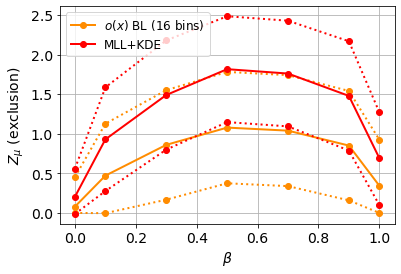

In [38]:
plt.figure()
lw = 2

plt.plot(beta, results_16bins_beta, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
plt.plot(beta, results_16bins_beta_plus, ':o', color='darkorange', lw=lw) 
plt.plot(beta, results_16bins_beta_min, ':o', color='darkorange', lw=lw) 

# plt.plot(beta, results_50bins_beta, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
# plt.plot(beta, results_50bins_beta_plus, ':o', color='blue', lw=lw) 
# plt.plot(beta, results_50bins_beta_min, ':o', color='blue', lw=lw) 

# plt.plot(beta, results_100bins_beta, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)')
# plt.plot(beta, results_100bins_beta_plus, ':o', color='dodgerblue', lw=lw) 
# plt.plot(beta, results_100bins_beta_min, ':o', color='dodgerblue', lw=lw) 

plt.plot(beta, results_MLL_KDE_beta, '-o', color='red', lw=lw, label=r'MLL+KDE')
plt.plot(beta, results_MLL_KDE_beta_plus, ':o', color='red', lw=lw) 
plt.plot(beta, results_MLL_KDE_beta_min, ':o', color='red', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
#plt.xscale('log')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(fontsize=12)
plt.show()